In [1]:
# -*- coding: utf-8 -*-
import csv
import tqdm
import copy
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 50
batch_size = 32
learning_rate = 1e-3
context_frames = 10
sequence_length = 20
lookback = sequence_length

context_epochs = 20
context_batch_size = 1
context_learning_rate = 1e-3
context_data_length = 20

valid_train_split = 0.8  # precentage of train data from total
test_train_split = 0.9  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available
################################# CHANGE THIS!!!!  #################################
model_path = "/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_001/"
################################# CHANGE THIS!!!!  #################################


In [2]:
class BatchGenerator:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        data_map = []
        with open(data_dir + 'map.csv', 'r') as f:  # rb
            reader = csv.reader(f)
            for row in reader:
                data_map.append(row)

        if len(data_map) <= 1: # empty or only header
            print("No file map found")
            exit()

        self.data_map = data_map

    def load_full_data(self):
        dataset_train = FullDataSet(self.data_dir, self.data_map, type_="train")
        dataset_valid = FullDataSet(self.data_dir, self.data_map, type_="valid")
        dataset_test = FullDataSet(self.data_dir, self.data_map, type_="test")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader


class FullDataSet():
    def __init__(self, data_dir, data_map, type_="train"):
        if type_ == "train":
            self.samples = data_map[1:int(len(data_map)*test_train_split)]
        elif type_ == "valid":
            self.samples = data_map[int(len(data_map)*(valid_train_split)):int(len(data_map)*test_train_split)]
        elif type_ == "test":
            self.samples = data_map[int(len(data_map)*test_train_split):-1]
        data_map = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        value = self.samples[idx]
        robot = np.load(data_dir + value[1])
        xela1 = np.load(data_dir + value[2])
        xela2 = np.load(data_dir + value[3])
        experiment = np.load(data_dir + value[-2])
        time_step  = np.load(data_dir + value[-1])  
        return([robot.astype(np.float32),
                 xela1.astype(np.float32),
                 xela2.astype(np.float32),
                 experiment,
                 time_step])
    
# class FullDataSet():
#     def __init__(self, data_dir, data_map, type_="train"):
#         dataset_full = []
#         for index, value in enumerate(data_map[1:]):  # ignore header
#             print(index, "/", len(data_map[1:]))
#             robot = np.load(data_dir + value[0])
#             xela1 = np.load(data_dir + value[2])
#             xela2 = np.load(data_dir + value[3])
#             experiment = np.load(data_dir + value[-2])
#             time_step  = np.load(data_dir + value[-1])
#             for i in range(len(robot)):
#                 dataset_full.append([robot[i].astype(np.float32),
#                                      xela1[i].astype(np.float32),
#                                      xela2[i].astype(np.float32),
#                                      experiment[i],
#                                      time_step[i]])
#         if type_ == "train":
#             self.samples = dataset_full[0:int(len(dataset_full)*test_train_split)]
#         elif type_ == "valid":
#             self.samples = dataset_full[int(len(dataset_full)*(valid_train_split)):int(len(dataset_full)*test_train_split)]
#         elif type_ == "test":
#             self.samples = dataset_full[int(len(dataset_full)*test_train_split):-1]

#         data_map = None

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self,idx):
#         return(self.samples[idx])

In [3]:
# class FullModel(nn.Module):
#     def __init__(self):
#         super(FullModel, self).__init__()
#         self.lstm1 = nn.LSTM(48, 48).to(device)  # tactile
#         self.lstm2 = nn.LSTM(6, 6).to(device)  # pos_vel
#         self.fc1 = nn.Linear(48+6, 48)  # tactile + pos_vel
#         self.lstm3 = nn.LSTM(48, 48).to(device)  # pos_vel

#     def forward(self, tactiles, actions):
#         state = actions[0]
#         state.to(device)
#         batch_size__ = tactiles.shape[1]
#         outputs = []
#         hidden1 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
#         hidden2 = (torch.rand(1,batch_size__,6).to(device), torch.rand(1,batch_size__,6).to(device))
#         hidden3 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
#         for index, (sample_tactile, sample_action) in enumerate(zip(tactiles.squeeze(), actions.squeeze())):
#             sample_tactile.to(device)
#             sample_action.to(device)
#             # 2. Run through lstm:
#             if index > context_frames-1:
#                 out1, hidden1 = self.lstm1(out4, hidden1)
#                 out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
#                 robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
#                 out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
#                 out4, hidden3 = self.lstm3(out3.to(device), hidden3)
#                 outputs.append(out4.squeeze())
#             else:
#                 out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
#                 out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
#                 robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
#                 out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
#                 out4, hidden3 = self.lstm3(out3.to(device), hidden3)

#         return torch.stack(outputs)

class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(48, 48).to(device)  # tactile
        self.lstm2 = nn.LSTM(7, 7).to(device)  # pos_vel
        self.fc1 = nn.Linear(48 + 49 + 48, 48).to(device)  # tactile + pos_vel

    def forward(self, tactiles, actions):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        hidden2 = (torch.rand(1,batch_size__,7).to(device), torch.rand(1,batch_size__,7).to(device))
        for index, (sample_tactile, sample_action) in enumerate(zip(tactiles.squeeze(), actions.squeeze())):
            sample_tactile.to(device)
            sample_action.to(device)
            # 2. Run through lstm:
            if index > context_frames-1:
                out1, hidden1 = self.lstm1(out3.to(device), hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                tactile_tiled = torch.cat((out2.squeeze(), out2.squeeze(), out2.squeeze(), out2.squeeze(), out2.squeeze(), out2.squeeze(), out2.squeeze()), 1)
                robot_and_tactile = torch.cat((tactile_tiled.squeeze(), out1.squeeze(), sample_tactile), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0))
                outputs.append(out3.squeeze())
            else:
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                tactile_tiled = torch.cat((out2.squeeze(), out2.squeeze(), out2.squeeze(), out2.squeeze(), out2.squeeze(), out2.squeeze(), out2.squeeze()), 1)
                robot_and_tactile = torch.cat((tactile_tiled.squeeze(), out1.squeeze(), sample_tactile), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0))

        return torch.stack(outputs)

In [4]:
class ModelTrainer:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.train_full_loader, self.valid_full_loader, self.test_full_loader = BG.load_full_data()
        self.full_model = FullModel()
        self.criterion = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        plot_training_loss = []
        plot_validation_loss = []
        previous_val_mean_loss = 100.0
        best_val_loss = 100.0
        early_stop_clock = 0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                action = batch_features[0].permute(1,0,2).to(device)
                tactile = batch_features[1].permute(1,0,2).to(device)

                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action) # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                loss = self.criterion(tactile_predictions.to(device), tactile[context_frames:])
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            plot_training_loss.append(mean)

            val_losses = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_full_loader):
                    action = batch_features[0].permute(1,0,2).to(device)
                    tactile = batch_features[1].permute(1,0,2).to(device)

                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action)  # Step 3. Run our forward pass.
                    self.optimizer.zero_grad()
                    val_loss = self.criterion(tactile_predictions.to(device), tactile[context_frames:])
                    val_losses += val_loss.item()

            print("Validation mean loss: {:.4f}, ".format(val_losses / index__))
            plot_validation_loss.append(val_losses / index__)
            if previous_val_mean_loss < val_losses / index__:
                early_stop_clock +=1
                previous_val_mean_loss = val_losses / index__ 
                if early_stop_clock == 2:
                    print("Early stopping")
                    break
            else:
                if best_val_loss > val_losses / index__:
                    self.strongest_model = copy.deepcopy(self.full_model)
                early_stop_clock = 0
                previous_val_mean_loss = val_losses / index__ 
        plt.plot(plot_training_loss, c="r", label="train loss MAE")
        plt.plot(plot_validation_loss, c='b', label="val loss MAE")
        plt.legend(loc="upper right")
        plt.show()
        np.save(model_path + 'concat_model_training_loss', np.asarray(plot_training_loss))
        np.save(model_path + 'concat_model_validation_loss', np.asarray(plot_validation_loss))


In [5]:
data_dir = '/home/user/Robotics/Data_sets/slip_detection/manual_slip_detection/'
BG = BatchGenerator(data_dir)
print("done")

done


In [ ]:
MT = ModelTrainer(data_dir)
MT.train_full_model()
print("finished training")
torch.save(MT.strongest_model, model_path + "concat_model_full_model")
model = torch.load(model_path + "concat_model_full_model")
model.eval()
print("saved the model")

epoch: 1, loss: 0.0111, mean loss: 0.0179, :   2%|▏         | 2845/142100 [03:40<47:57:32,  1.24s/it]

Validation mean loss: 0.0095, 


epoch: 2, loss: 0.0066, mean loss: 0.0100, :   4%|▍         | 5688/142100 [06:21<41:25:47,  1.09s/it]

Validation mean loss: 0.0060, 


epoch: 3, loss: 0.0047, mean loss: 0.0066, :   6%|▌         | 8530/142100 [09:02<45:12:11,  1.22s/it]

Validation mean loss: 0.0045, 


epoch: 4, loss: 0.0040, mean loss: 0.0060, :   8%|▊         | 11372/142100 [11:43<44:22:20,  1.22s/it]

Validation mean loss: 0.0038, 


epoch: 5, loss: 0.0029, mean loss: 0.0048, :  10%|█         | 14214/142100 [14:23<42:36:36,  1.20s/it]

Validation mean loss: 0.0033, 


epoch: 6, loss: 0.0028, mean loss: 0.0042, :  12%|█▏        | 17056/142100 [17:02<42:41:02,  1.23s/it]

Validation mean loss: 0.0029, 


epoch: 7, loss: 0.0023, mean loss: 0.0034, :  14%|█▍        | 19898/142100 [19:44<41:47:37,  1.23s/it]

Validation mean loss: 0.0025, 


epoch: 8, loss: 0.0026, mean loss: 0.0037, :  16%|█▌        | 22740/142100 [22:25<40:42:11,  1.23s/it]

Validation mean loss: 0.0022, 


epoch: 9, loss: 0.0022, mean loss: 0.0032, :  18%|█▊        | 25582/142100 [25:04<40:14:12,  1.24s/it]

Validation mean loss: 0.0023, 


epoch: 10, loss: 0.0022, mean loss: 0.0030, :  20%|██        | 28424/142100 [27:45<39:08:36,  1.24s/it]

Validation mean loss: 0.0017, 


epoch: 11, loss: 0.0019, mean loss: 0.0027, :  22%|██▏       | 31266/142100 [30:26<37:55:33,  1.23s/it]

Validation mean loss: 0.0019, 


epoch: 12, loss: 0.0018, mean loss: 0.0027, :  24%|██▍       | 34108/142100 [33:08<36:37:40,  1.22s/it]

Validation mean loss: 0.0018, 


epoch: 13, loss: 0.0018, mean loss: 0.0030, :  26%|██▌       | 36950/142100 [35:49<35:15:04,  1.21s/it]

Validation mean loss: 0.0023, 


epoch: 14, loss: 0.0022, mean loss: 0.0030, :  28%|██▊       | 39792/142100 [38:31<36:07:14,  1.27s/it]

Validation mean loss: 0.0021, 


epoch: 15, loss: 0.0016, mean loss: 0.0023, :  30%|███       | 42634/142100 [41:13<34:41:47,  1.26s/it]

Validation mean loss: 0.0017, 


epoch: 16, loss: 0.0018, mean loss: 0.0026, :  32%|███▏      | 45476/142100 [43:54<32:46:20,  1.22s/it]

Validation mean loss: 0.0017, 


epoch: 17, loss: 0.0018, mean loss: 0.0027, :  34%|███▍      | 48318/142100 [46:36<32:07:48,  1.23s/it]

Validation mean loss: 0.0020, 


epoch: 17, loss: 0.0022, mean loss: 0.0019, :  36%|███▌      | 51156/142100 [49:05<1:19:15, 19.13it/s] 

In [83]:
model = torch.load(model_path + "concat_model_full_model")
model.eval()

FullModel(
  (lstm1): LSTM(48, 48)
  (lstm2): LSTM(7, 7)
  (fc1): Linear(in_features=145, out_features=48, bias=True)
)

In [85]:
# test model on the full test sample:
# model = MT.strongest_model
data_dir = MT.data_dir

criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()

test_lossesMAE_x = 0.0
test_lossesMSE_x = 0.0
test_lossesMAE_y = 0.0
test_lossesMSE_y = 0.0
test_lossesMAE_z = 0.0
test_lossesMSE_z = 0.0

test_lossesMAE_t1 = 0.0
test_lossesMSE_t1 = 0.0
test_lossesMAE_t5 = 0.0
test_lossesMSE_t5 = 0.0
test_lossesMAE_t10 = 0.0
test_lossesMSE_t10 = 0.0

test_lossesMAE_x_ts1 = 0.0
test_lossesMSE_x_ts1 = 0.0
test_lossesMAE_y_ts1 = 0.0
test_lossesMSE_y_ts1 = 0.0
test_lossesMAE_z_ts1 = 0.0
test_lossesMSE_z_ts1 = 0.0

test_lossesMAE_x_ts5 = 0.0
test_lossesMSE_x_ts5 = 0.0
test_lossesMAE_y_ts5 = 0.0
test_lossesMSE_y_ts5 = 0.0
test_lossesMAE_z_ts5 = 0.0
test_lossesMSE_z_ts5 = 0.0

test_lossesMAE_x_ts10 = 0.0
test_lossesMSE_x_ts10 = 0.0
test_lossesMAE_y_ts10 = 0.0
test_lossesMSE_y_ts10 = 0.0
test_lossesMAE_z_ts10 = 0.0
test_lossesMSE_z_ts10 = 0.0

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(MT.test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)

        tp = model.forward(tactiles=tactile, actions=action)
        experiment_time_steps.append([batch_features[3], batch_features[4]])
        tactile_predictions.append(tp)  # Step 3. Run our forward pass.
        tactile_groundtruth.append(tactile[context_frames:])
        # calculate losses for specific timesteps
        test_lossMAE_t1 = criterion1(tp[0,:,:].to(device), tactile[context_frames:][0,:,:])
        test_lossesMAE_t1 += test_lossMAE_t1.item() 
        test_lossMSE_t1 = criterion2(tp[0,:,:].to(device), tactile[context_frames:][0,:,:])
        test_lossesMSE_t1 += test_lossMSE_t1.item() 
        test_lossMAE_t5 = criterion1(tp[4,:,:].to(device), tactile[context_frames:][4,:,:])
        test_lossesMAE_t5 += test_lossMAE_t5.item() 
        test_lossMSE_t5 = criterion2(tp[4,:,:].to(device), tactile[context_frames:][4,:,:])
        test_lossesMSE_t5 += test_lossMSE_t5.item() 
        test_lossMAE_t10 = criterion1(tp[9,:,:].to(device), tactile[context_frames:][9,:,:])
        test_lossesMAE_t10 += test_lossMAE_t10.item() 
        test_lossMSE_t10 = criterion2(tp[9,:,:].to(device), tactile[context_frames:][9,:,:])
        test_lossesMSE_t10 += test_lossMSE_t10.item() 
        
        # calculate losses for specific forces
        test_lossMAE_x = criterion1(tp[:,:,:16].to(device), tactile[context_frames:][:,:,:16])
        test_lossesMAE_x += test_lossMAE_x.item() 
        test_lossMSE_x = criterion2(tp[:,:,:16].to(device), tactile[context_frames:][:,:,:16])
        test_lossesMSE_x += test_lossMSE_x.item() 
        test_lossMAE_y = criterion1(tp[:,:,17:32].to(device), tactile[context_frames:][:,:,17:32])
        test_lossesMAE_y += test_lossMAE_y.item() 
        test_lossMSE_y = criterion2(tp[:,:,17:32].to(device), tactile[context_frames:][:,:,17:32])
        test_lossesMSE_y += test_lossMSE_y.item() 
        test_lossMAE_z = criterion1(tp[:,:,33:48].to(device), tactile[context_frames:][:,:,33:48])
        test_lossesMAE_z += test_lossMAE_z.item() 
        test_lossMSE_z = criterion2(tp[:,:,33:48].to(device), tactile[context_frames:][:,:,33:48])
        test_lossesMSE_z += test_lossMSE_z.item() 

        # calculate losses for specific timesteps and forces 
        test_lossMAE_x_ts1 = criterion1(tp[0,:,:16].to(device), tactile[context_frames:][0,:,:16])
        test_lossesMAE_x_ts1 += test_lossMAE_x_ts1.item() 
        test_lossMSE_x_ts1 = criterion2(tp[0,:,:16].to(device), tactile[context_frames:][0,:,:16])
        test_lossesMSE_x_ts1 += test_lossMSE_x_ts1.item() 
        test_lossMAE_y_ts1 = criterion1(tp[0,:,17:32].to(device), tactile[context_frames:][0,:,17:32])
        test_lossesMAE_y_ts1 += test_lossMAE_y_ts1.item() 
        test_lossMSE_y_ts1 = criterion2(tp[0,:,17:32].to(device), tactile[context_frames:][0,:,17:32])
        test_lossesMSE_y_ts1 += test_lossMSE_y_ts1.item() 
        test_lossMAE_z_ts1 = criterion1(tp[0,:,33:48].to(device), tactile[context_frames:][0,:,33:48])
        test_lossesMAE_z_ts1 += test_lossMAE_z_ts1.item() 
        test_lossMSE_z_ts1 = criterion2(tp[0,:,33:48].to(device), tactile[context_frames:][0,:,33:48])
        test_lossesMSE_z_ts1 += test_lossMSE_z_ts1.item() 
 
        test_lossMAE_x_ts5 = criterion1(tp[4,:,:16].to(device), tactile[context_frames:][4,:,:16])
        test_lossesMAE_x_ts5 += test_lossMAE_x_ts5.item() 
        test_lossMSE_x_ts5 = criterion2(tp[4,:,:16].to(device), tactile[context_frames:][4,:,:16])
        test_lossesMSE_x_ts5 += test_lossMSE_x_ts5.item() 
        test_lossMAE_y_ts5 = criterion1(tp[4,:,17:32].to(device), tactile[context_frames:][4,:,17:32])
        test_lossesMAE_y_ts5 += test_lossMAE_y_ts5.item() 
        test_lossMSE_y_ts5 = criterion2(tp[4,:,17:32].to(device), tactile[context_frames:][4,:,17:32])
        test_lossesMSE_y_ts5 += test_lossMSE_y_ts5.item() 
        test_lossMAE_z_ts5 = criterion1(tp[4,:,33:48].to(device), tactile[context_frames:][4,:,33:48])
        test_lossesMAE_z_ts5 += test_lossMAE_z_ts5.item() 
        test_lossMSE_z_ts5 = criterion2(tp[4,:,33:48].to(device), tactile[context_frames:][4,:,33:48])
        test_lossesMSE_z_ts5 += test_lossMSE_z_ts5.item() 

        test_lossMAE_x_ts10 = criterion1(tp[9,:,:16].to(device), tactile[context_frames:][9,:,:16])
        test_lossesMAE_x_ts10 += test_lossMAE_x_ts10.item() 
        test_lossMSE_x_ts10 = criterion2(tp[9,:,:16].to(device), tactile[context_frames:][9,:,:16])
        test_lossesMSE_x_ts10 += test_lossMSE_x_ts10.item() 
        test_lossMAE_y_ts10 = criterion1(tp[9,:,17:32].to(device), tactile[context_frames:][9,:,17:32])
        test_lossesMAE_y_ts10 += test_lossMAE_y_ts10.item() 
        test_lossMSE_y_ts10 = criterion2(tp[9,:,17:32].to(device), tactile[context_frames:][9,:,17:32])
        test_lossesMSE_y_ts10 += test_lossMSE_y_ts10.item() 
        test_lossMAE_z_ts10 = criterion1(tp[9,:,33:48].to(device), tactile[context_frames:][9,:,33:48])
        test_lossesMAE_z_ts10 += test_lossMAE_z_ts10.item() 
        test_lossMSE_z_ts10 = criterion2(tp[9,:,33:48].to(device), tactile[context_frames:][9,:,33:48])
        test_lossesMSE_z_ts10 += test_lossMSE_z_ts10.item()

performance_data = []
performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
performance_data.append(["test loss MSE: ", (test_lossesMSE / index__)])
performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_x / index__)])
performance_data.append(["test loss MSE timestep 1: ", (test_lossesMSE_x / index__)])
performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_y / index__)])
performance_data.append(["test loss MSE timestep 5: ", (test_lossesMSE_y / index__)])
performance_data.append(["test loss MAE(L1) timestep 10: ", (test_lossesMAE_z / index__)])
performance_data.append(["test loss MSE timestep 10: ", (test_lossesMSE_z / index__)])
performance_data.append(["sheer x test loss MAE(L1): ", (test_lossesMAE_x / index__)])
performance_data.append(["sheer x test loss MSE: ", (test_lossesMSE_x / index__)])
performance_data.append(["sheer y test loss MAE(L1): ", (test_lossesMAE_y / index__)])
performance_data.append(["sheer y test loss MSE: ", (test_lossesMSE_y / index__)])
performance_data.append(["z test loss MAE(L1): ", (test_lossesMAE_z / index__)])
performance_data.append(["z test loss MSE: ", (test_lossesMSE_z / index__)])
performance_data.append(["sheer x test loss MAE(L1) timestep 1: ", (test_lossesMAE_x_ts1 / index__)])
performance_data.append(["sheer x test loss MSE timestep 1: ", (test_lossesMSE_x_ts1 / index__)])
performance_data.append(["sheer y test loss MAE(L1) timestep 1: ", (test_lossesMAE_y_ts1 / index__)])
performance_data.append(["sheer y test loss MSE timestep 1: ", (test_lossesMSE_y_ts1 / index__)])
performance_data.append(["z test loss MAE(L1) timestep 1: ", (test_lossesMAE_z_ts1 / index__)])
performance_data.append(["z test loss MSE timestep 1: ", (test_lossesMSE_z_ts1 / index__)])
performance_data.append(["sheer x test loss MAE(L1) timestep 5: ", (test_lossesMAE_x_ts5 / index__)])
performance_data.append(["sheer x test loss MSE timestep 5: ", (test_lossesMSE_x_ts5 / index__)])
performance_data.append(["sheer y test loss MAE(L1) timestep 5: ", (test_lossesMAE_y_ts5 / index__)])
performance_data.append(["sheer y test loss MSE timestep 5: ", (test_lossesMSE_y_ts5 / index__)])
performance_data.append(["z test loss MAE(L1) timestep 5: ", (test_lossesMAE_z_ts5 / index__)])
performance_data.append(["z test loss MSE timestep 5: ", (test_lossesMSE_z_ts5 / index__)])
performance_data.append(["sheer x test loss MAE(L1) timestep 10: ", (test_lossesMAE_x_ts10 / index__)])
performance_data.append(["sheer x test loss MSE timestep 10: ", (test_lossesMSE_x_ts10 / index__)])
performance_data.append(["sheer y test loss MAE(L1) timestep 10: ", (test_lossesMAE_y_ts10 / index__)])
performance_data.append(["sheer y test loss MSE timestep 10: ", (test_lossesMSE_y_ts10 / index__)])
performance_data.append(["z test loss MAE(L1) timestep 10: ", (test_lossesMAE_z_ts10 / index__)])
performance_data.append(["z test loss MSE timestep 10: ", (test_lossesMSE_z_ts10 / index__)])
[print(i) for i in performance_data]

np.save(model_path + 'concat_model_performance_data', np.asarray(performance_data))

# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t9 = 5
predicted_data_t1 = []
predicted_data_t9 = []
groundtruth_data = []
for index, batch_set in enumerate(tactile_predictions):
    for batch in range(0, len(batch_set[0])):
        prediction_values = batch_set[time_step_to_test_t1][batch]
        predicted_data_t1.append(prediction_values)
        prediction_values = batch_set[time_step_to_test_t9][batch]
        predicted_data_t9.append(prediction_values)
        gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
        groundtruth_data.append(gt_values)  
print("done")

['test loss MAE(L1): ', 0.0]
['test loss MSE: ', 0.0]
['test loss MAE(L1) timestep 1: ', 0.0015885328583877592]
['test loss MSE timestep 1: ', 4.991811797914297e-06]
['test loss MAE(L1) timestep 5: ', 0.0022552393709442445]
['test loss MSE timestep 5: ', 9.113836495811165e-06]
['test loss MAE(L1) timestep 10: ', 0.0013639963230132938]
['test loss MSE timestep 10: ', 4.038242032254943e-06]
['sheer x test loss MAE(L1): ', 0.0015885328583877592]
['sheer x test loss MSE: ', 4.991811797914297e-06]
['sheer y test loss MAE(L1): ', 0.0022552393709442445]
['sheer y test loss MSE: ', 9.113836495811165e-06]
['z test loss MAE(L1): ', 0.0013639963230132938]
['z test loss MSE: ', 4.038242032254943e-06]
['sheer x test loss MAE(L1) timestep 1: ', 0.0015884640340190677]
['sheer x test loss MSE timestep 1: ', 4.9914773839306675e-06]
['sheer y test loss MAE(L1) timestep 1: ', 0.002255086974048662]
['sheer y test loss MSE timestep 1: ', 9.114189994025288e-06]
['z test loss MAE(L1) timestep 1: ', 0.0013639

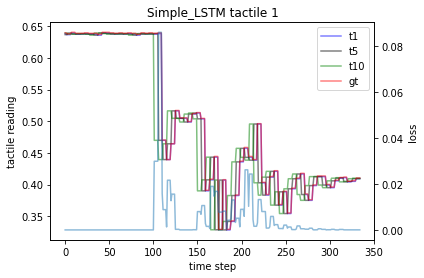

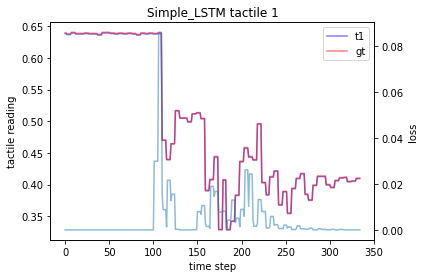

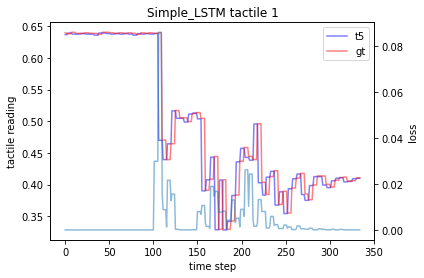

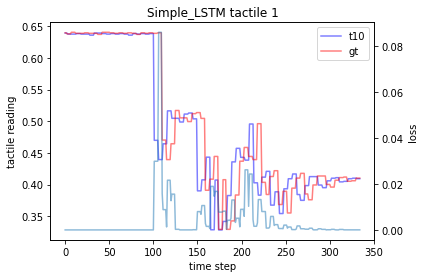

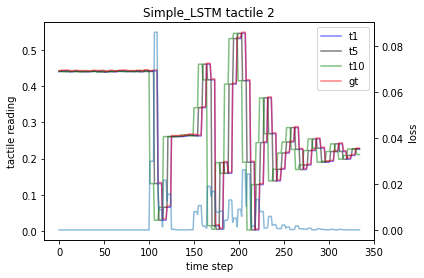

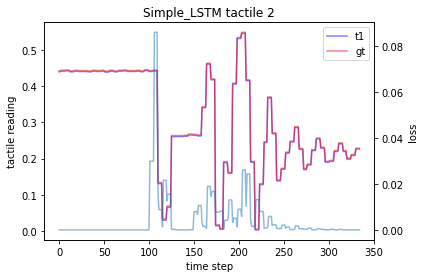

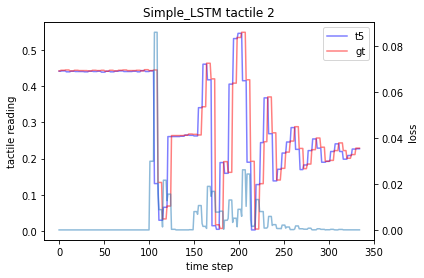

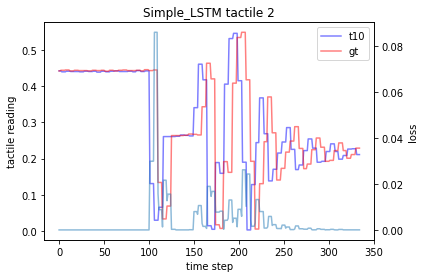

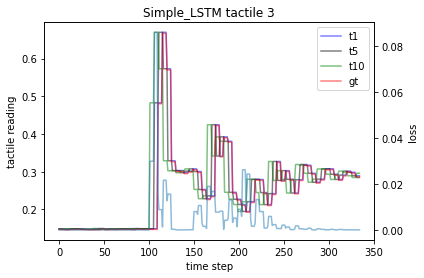

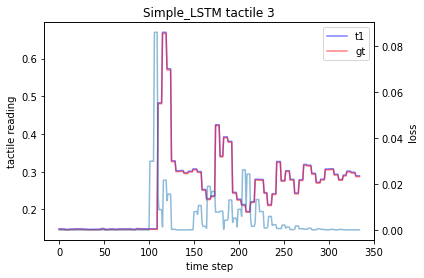

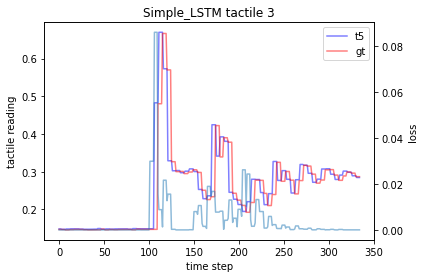

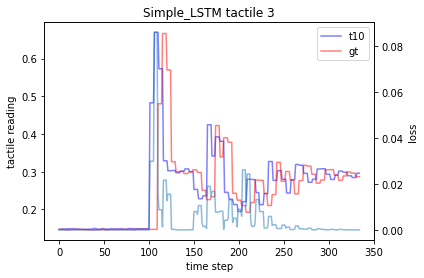

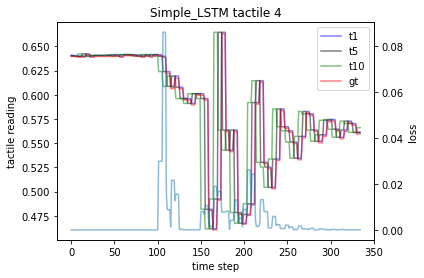

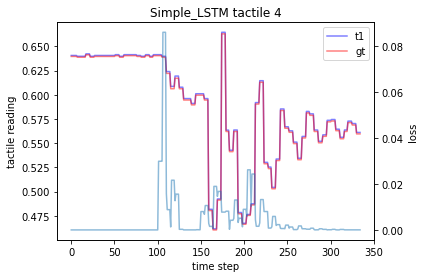

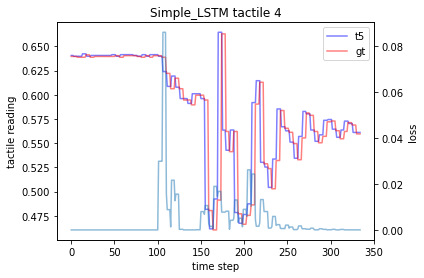

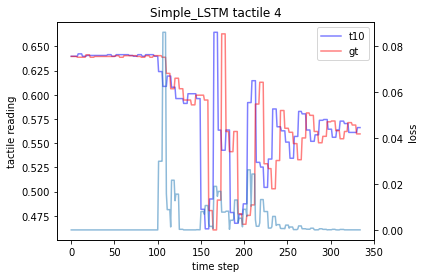

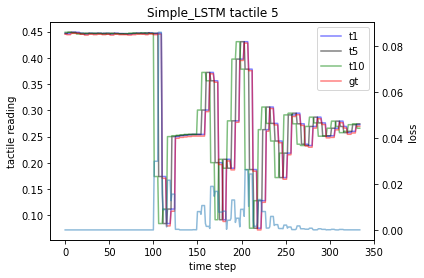

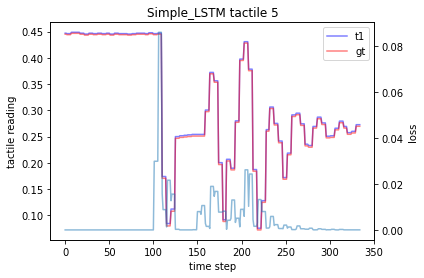

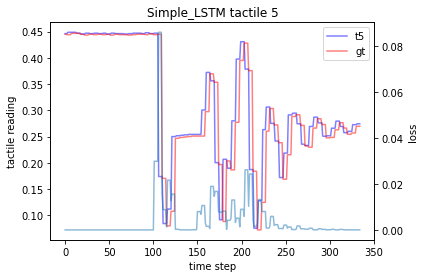

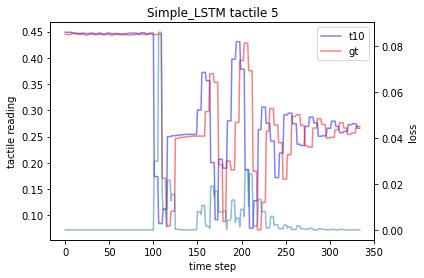

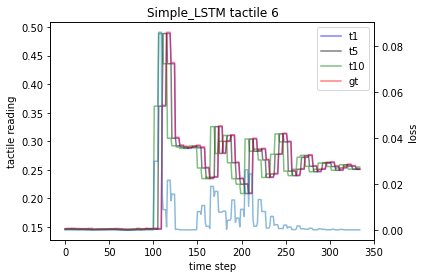

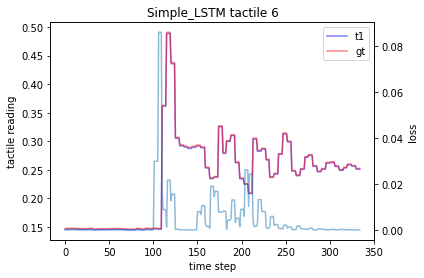

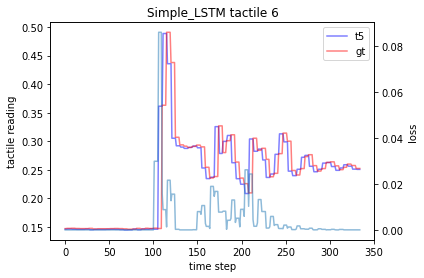

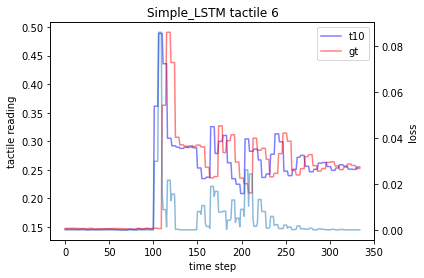

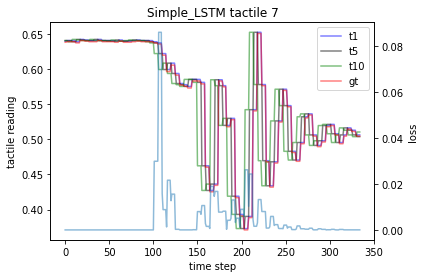

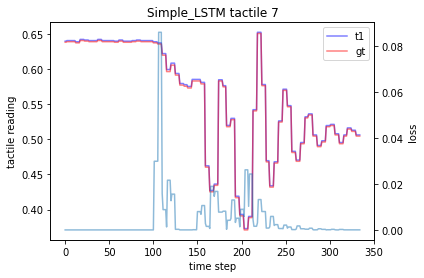

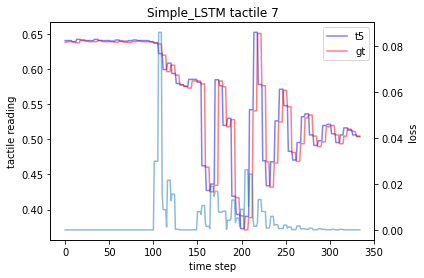

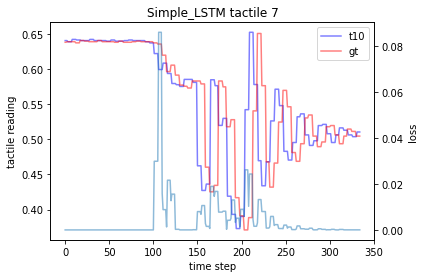

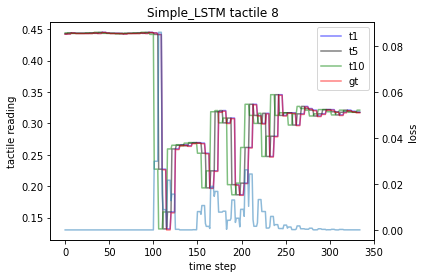

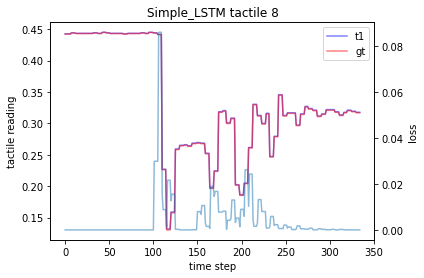

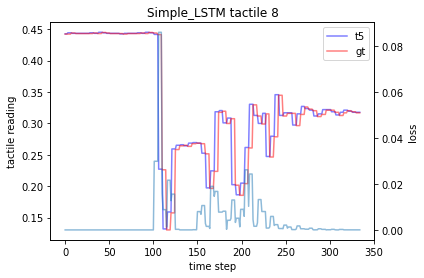

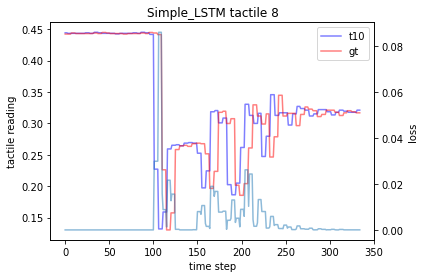

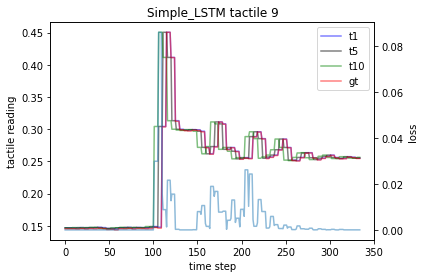

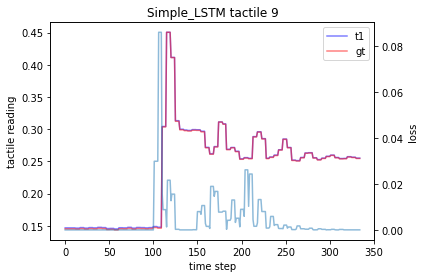

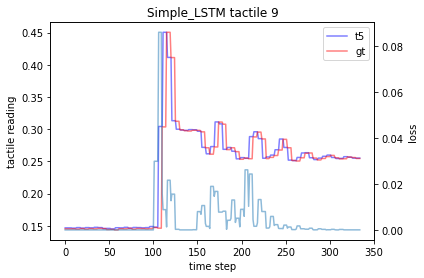

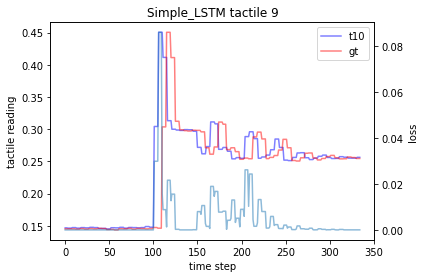

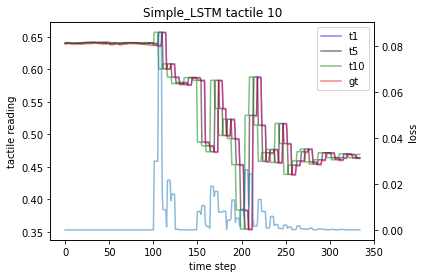

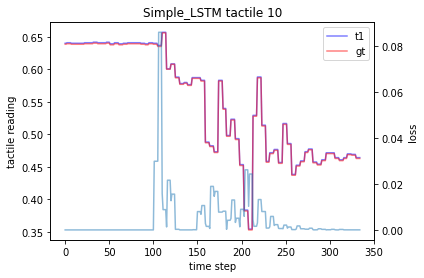

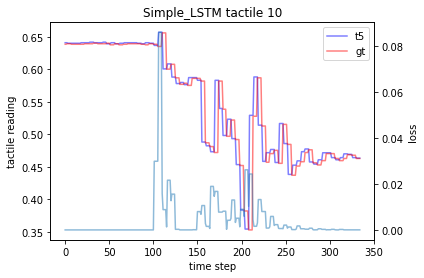

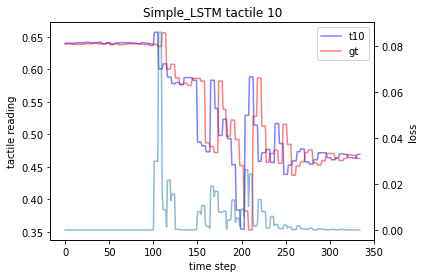

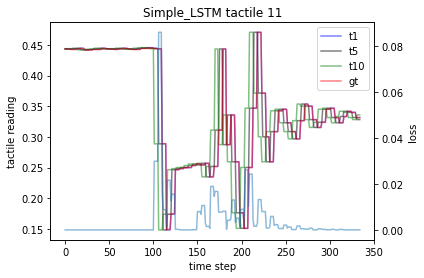

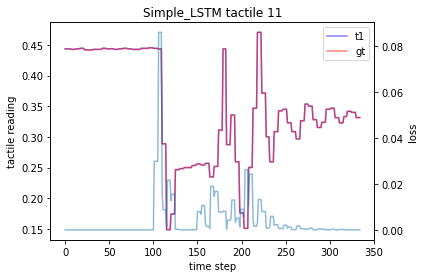

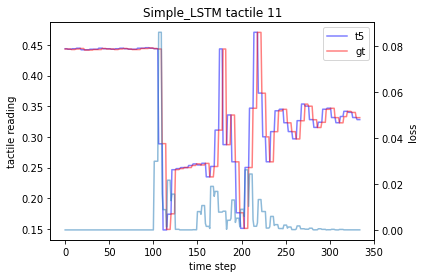

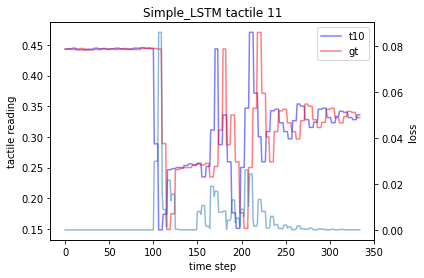

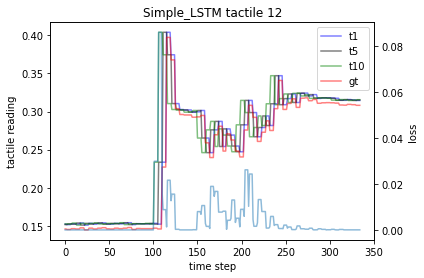

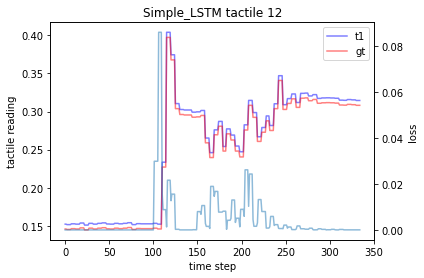

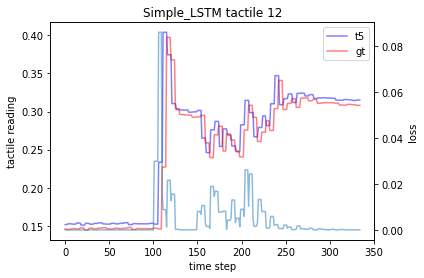

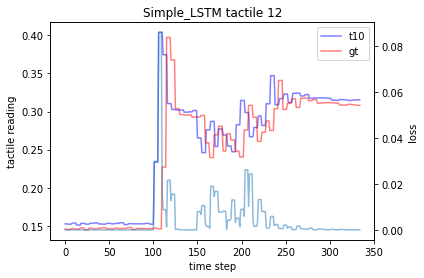

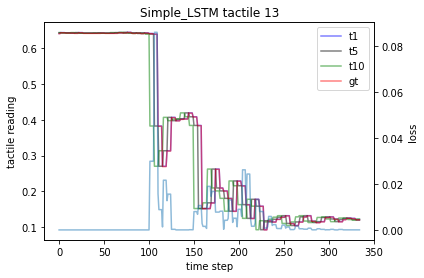

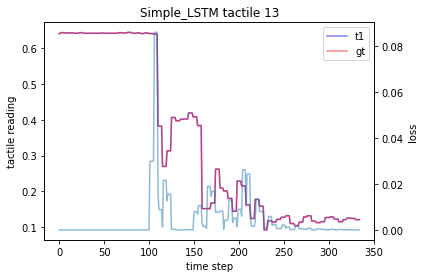

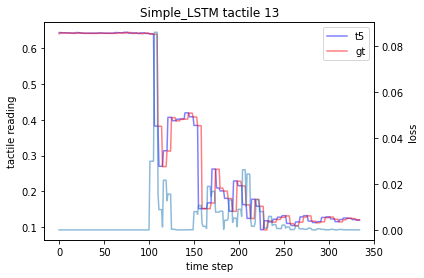

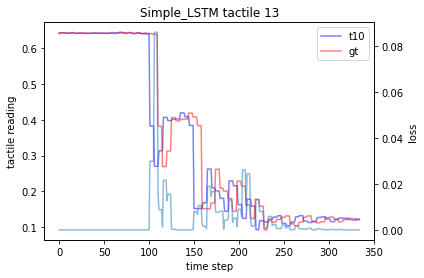

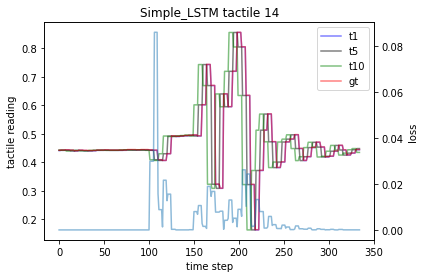

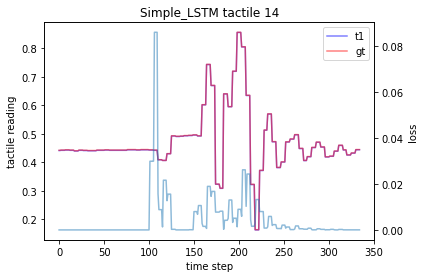

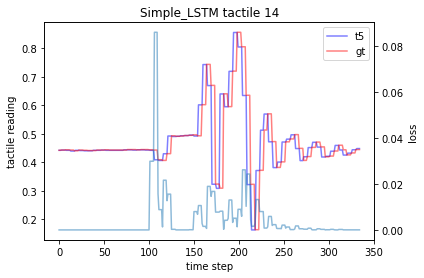

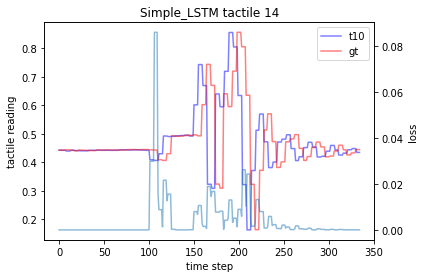

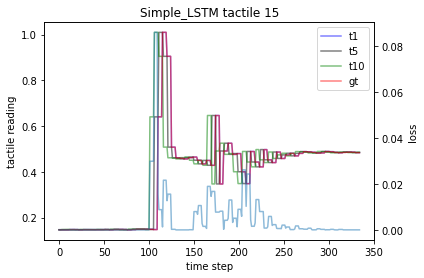

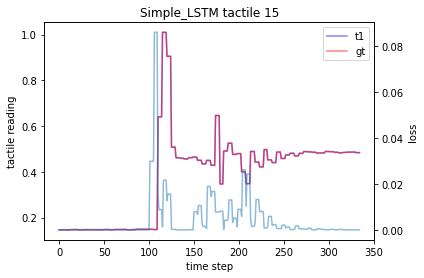

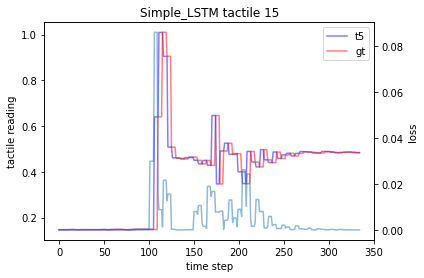

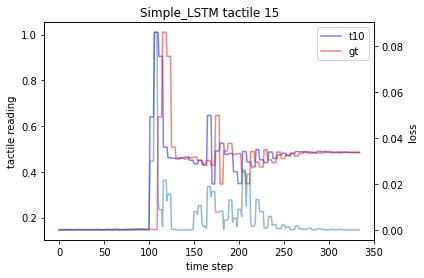

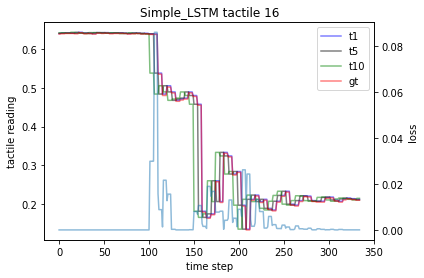

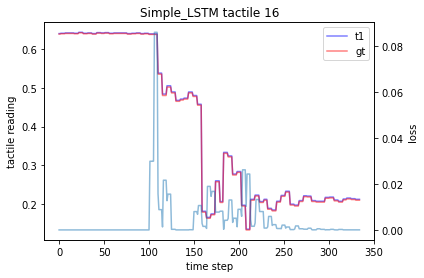

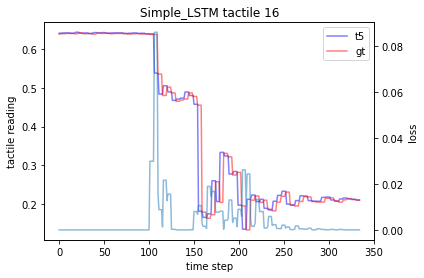

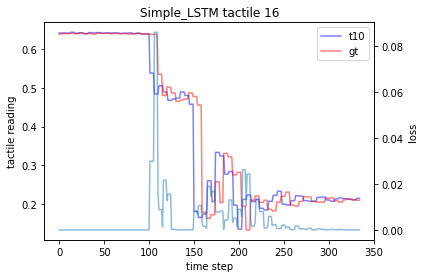

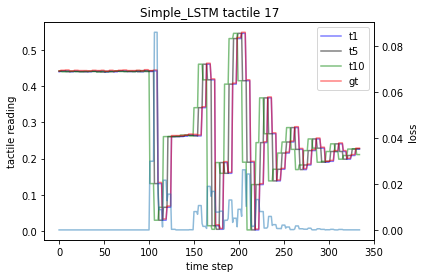

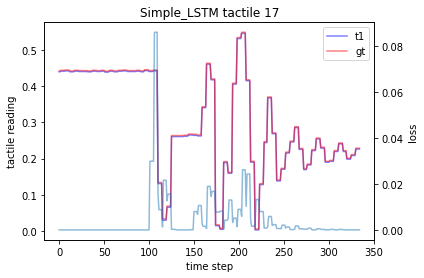

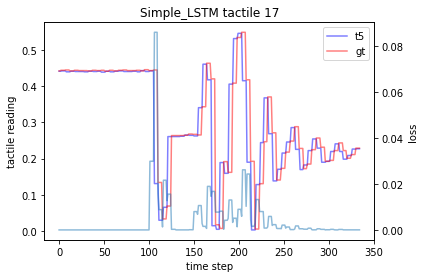

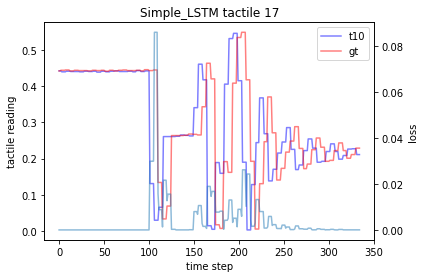

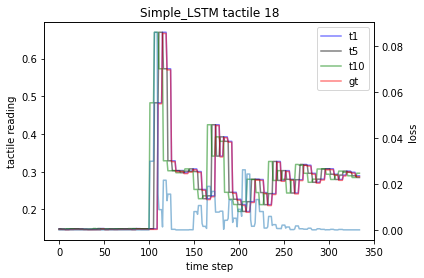

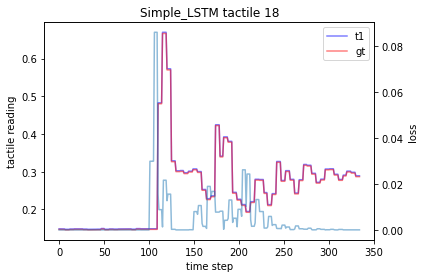

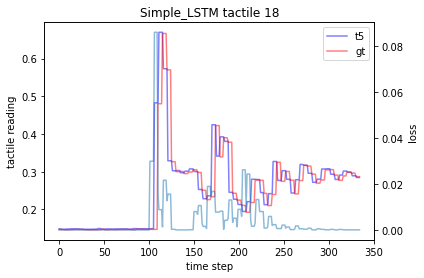

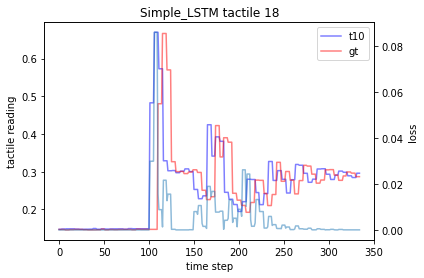

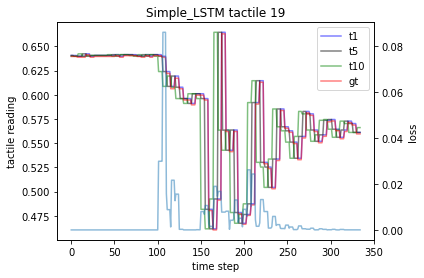

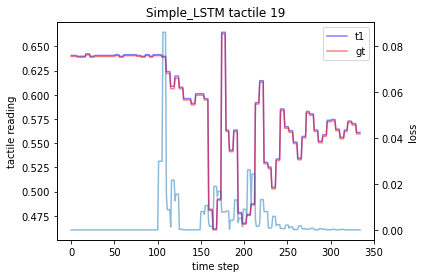

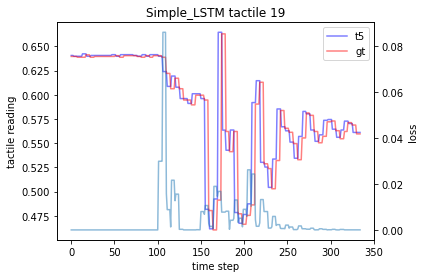

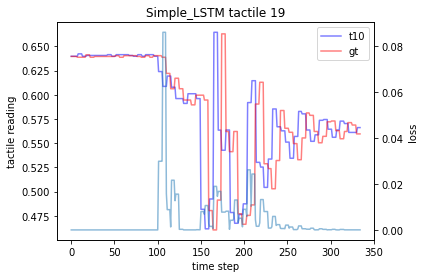

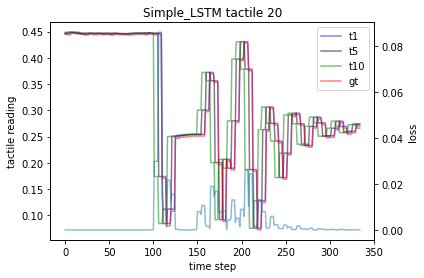

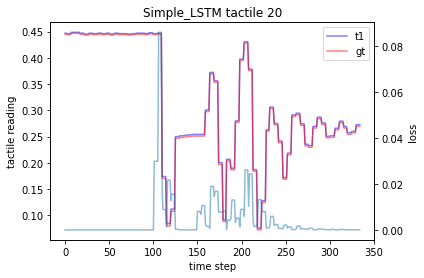

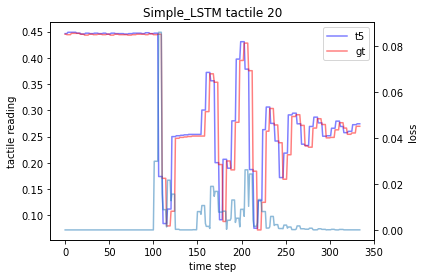

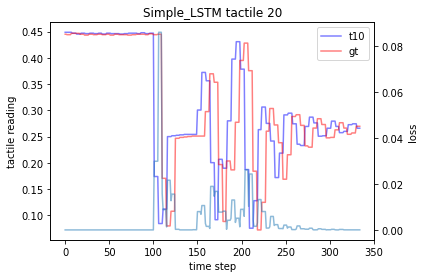

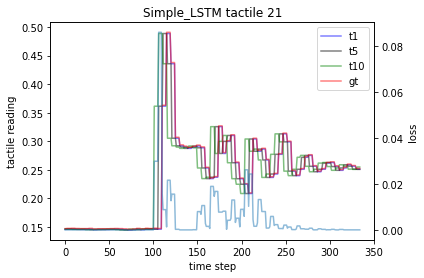

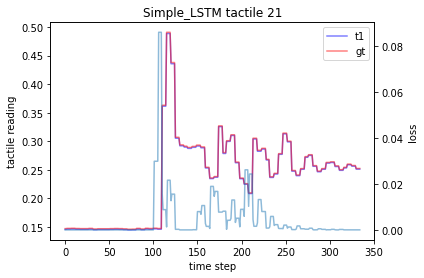

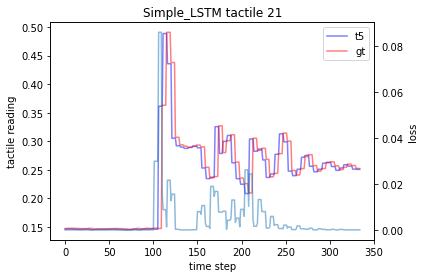

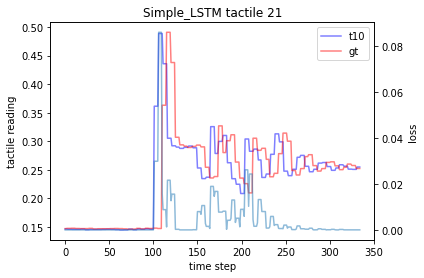

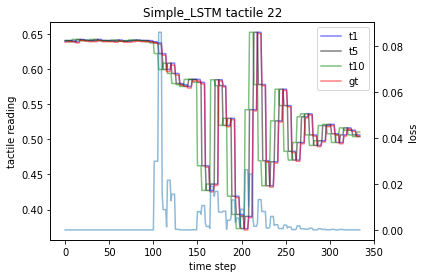

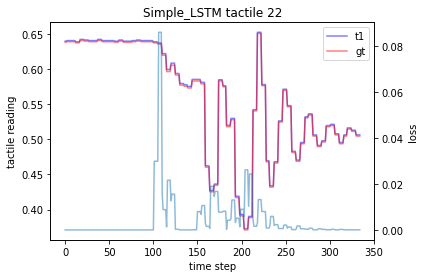

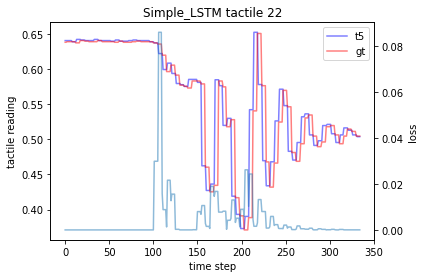

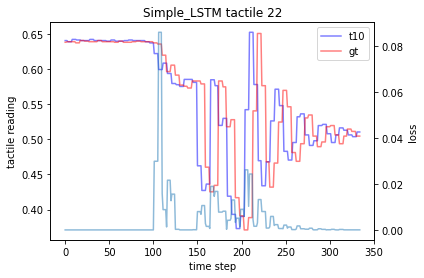

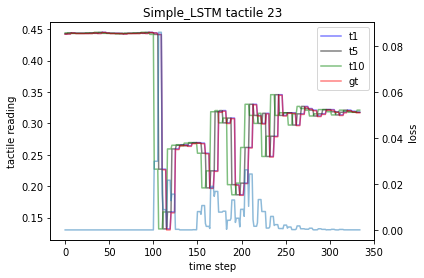

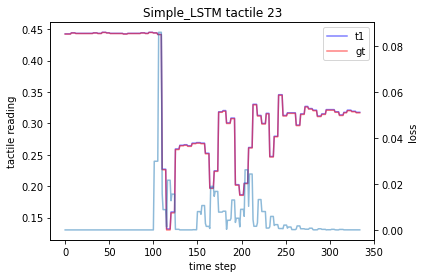

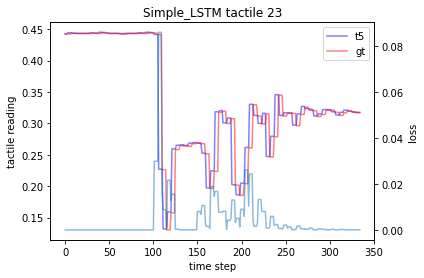

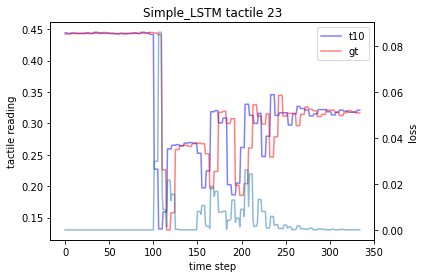

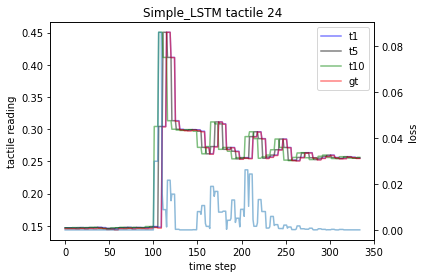

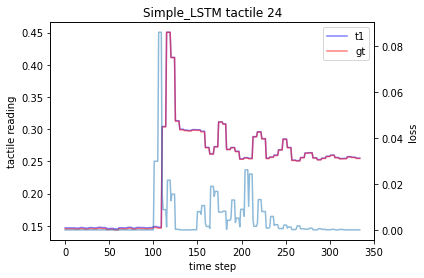

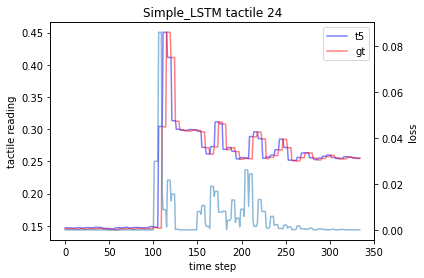

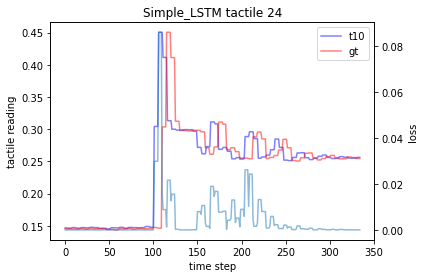

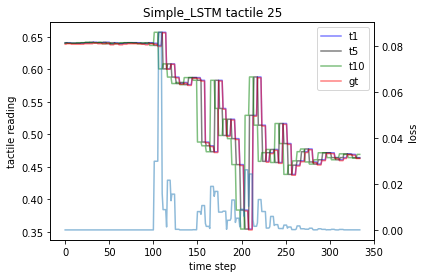

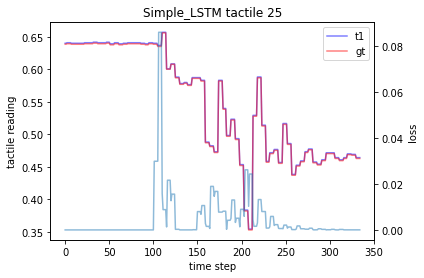

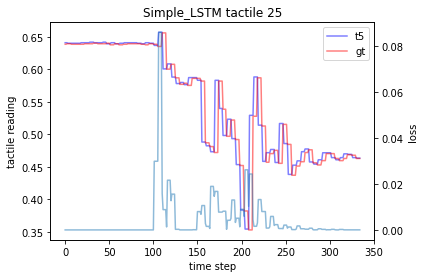

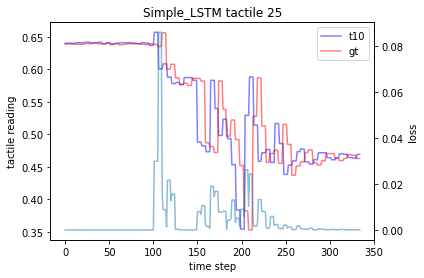

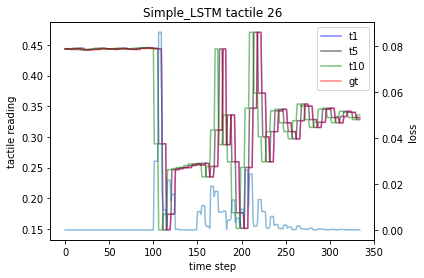

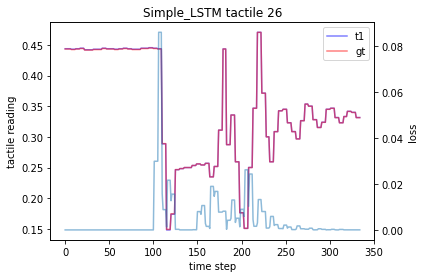

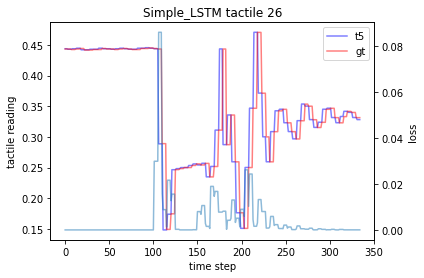

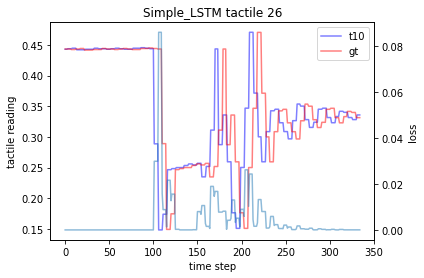

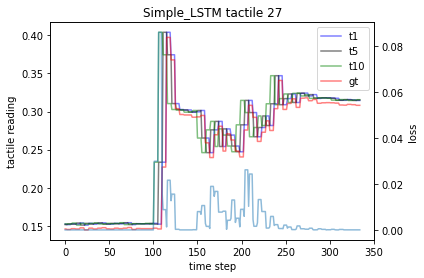

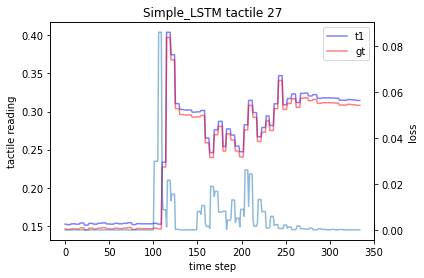

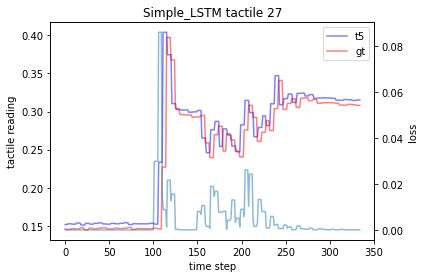

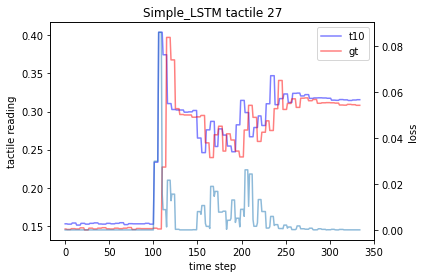

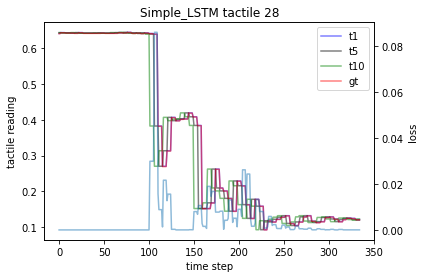

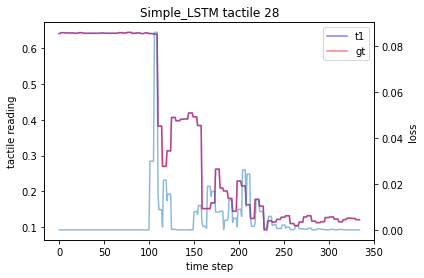

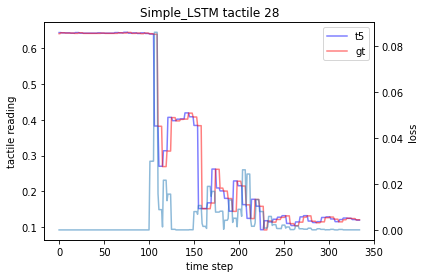

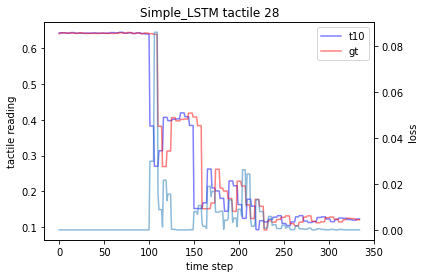

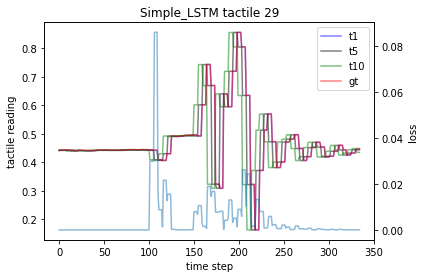

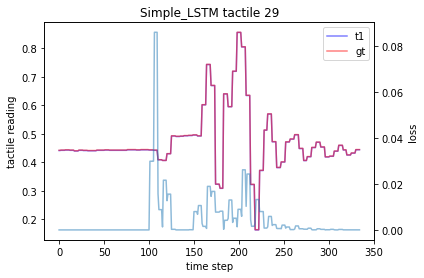

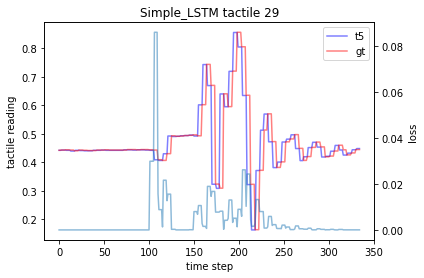

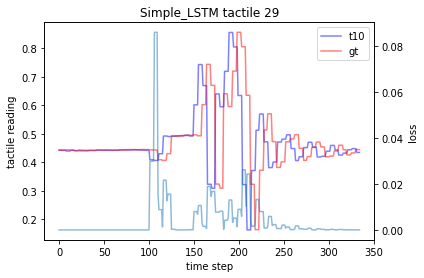

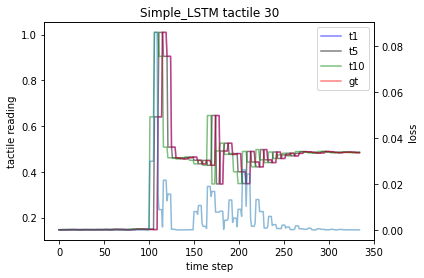

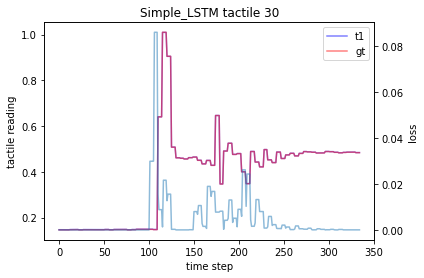

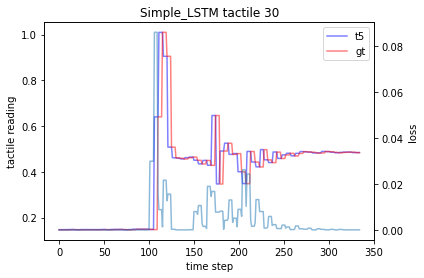

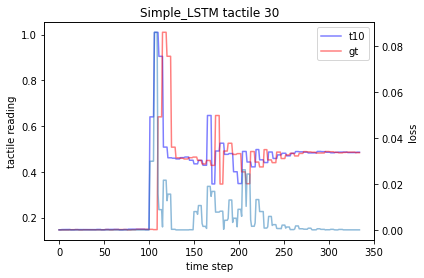

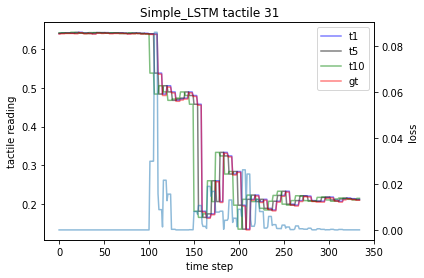

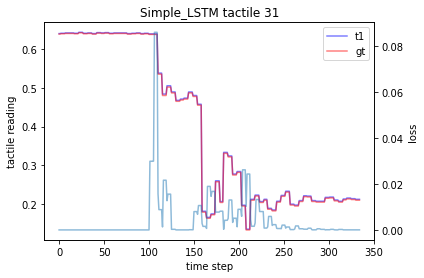

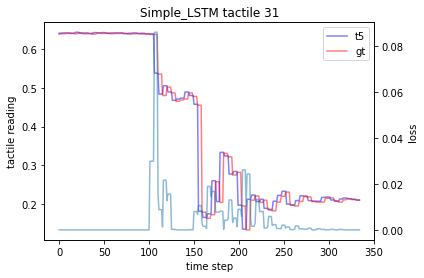

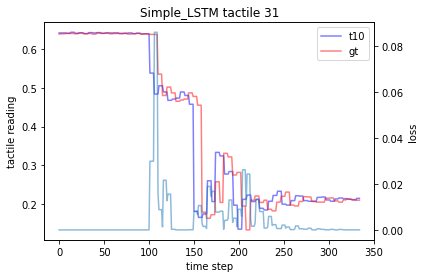

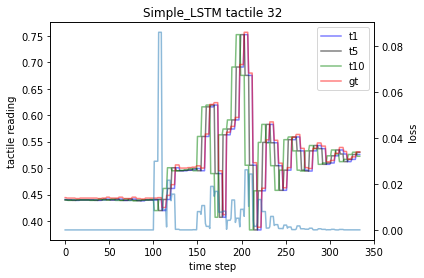

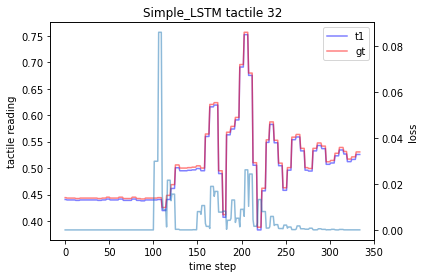

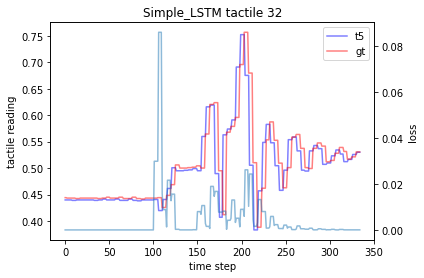

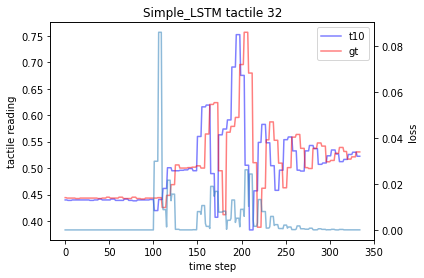

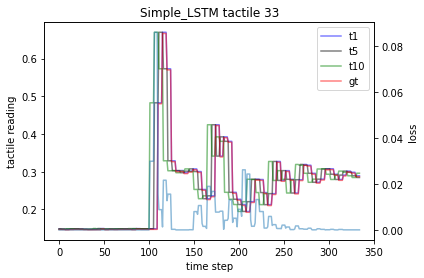

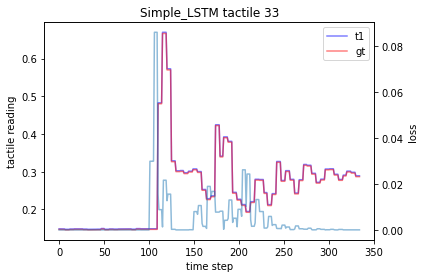

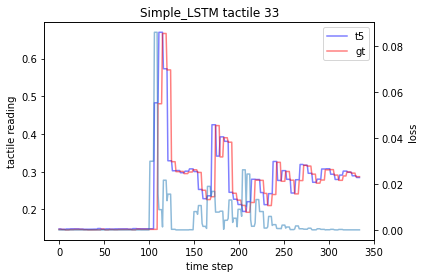

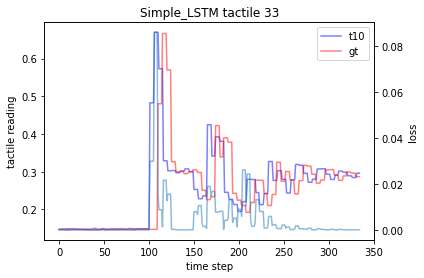

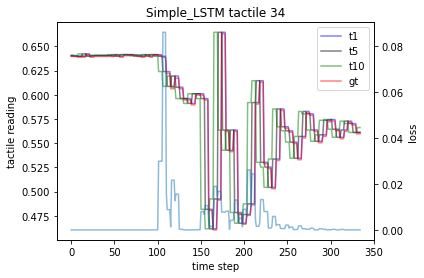

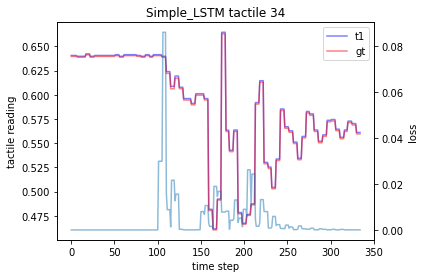

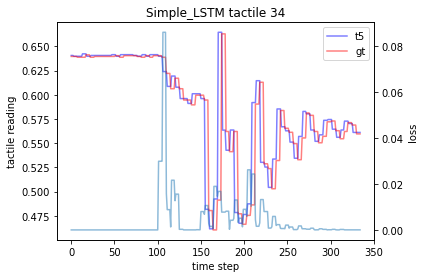

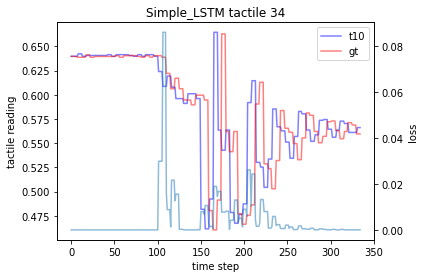

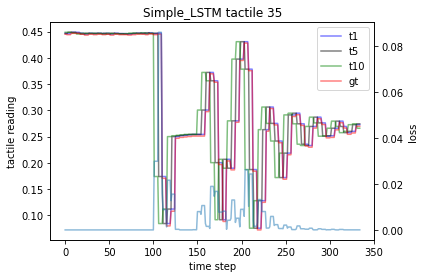

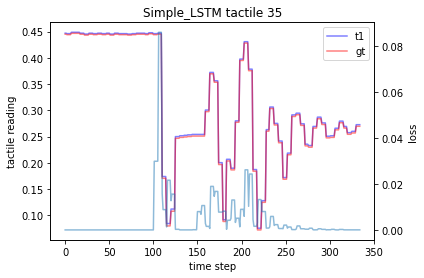

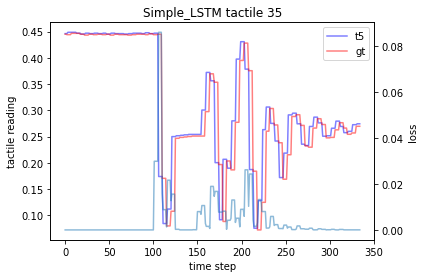

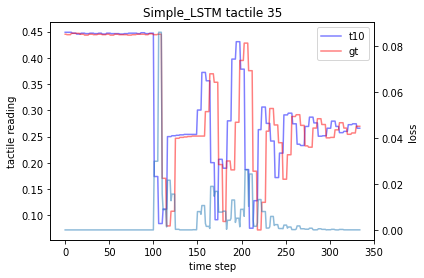

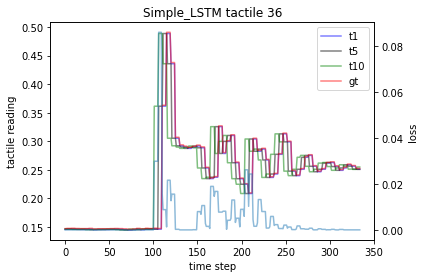

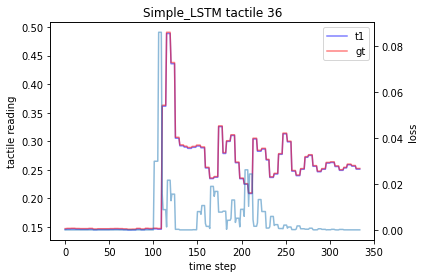

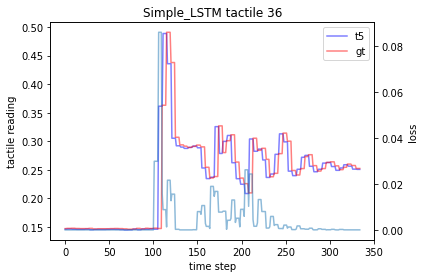

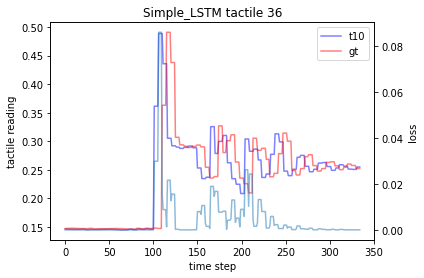

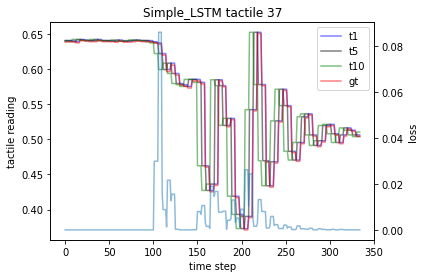

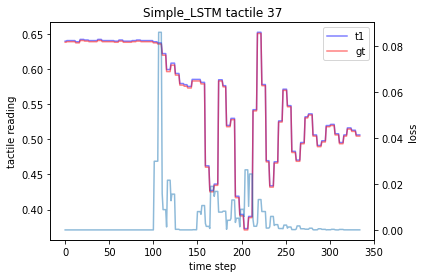

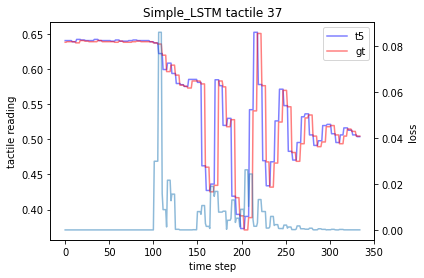

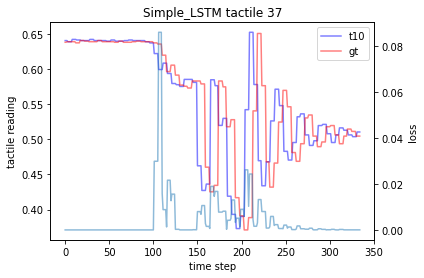

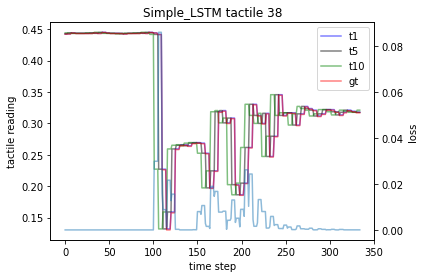

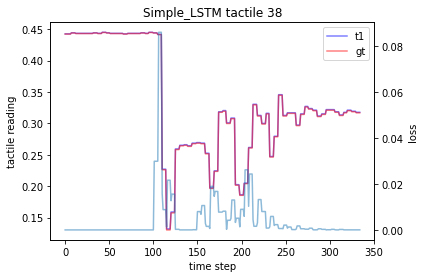

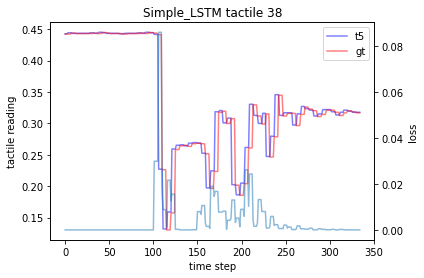

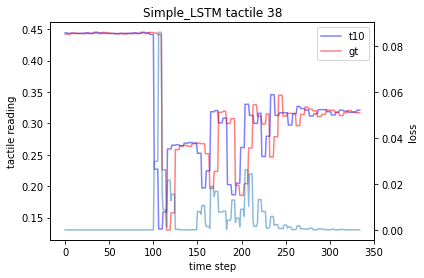

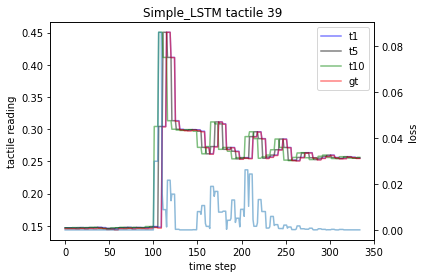

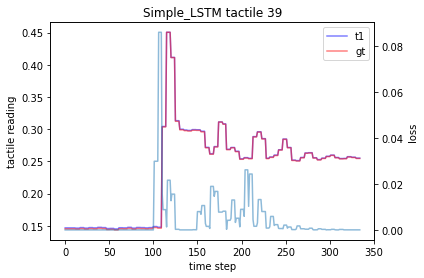

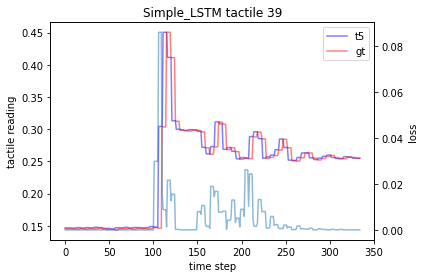

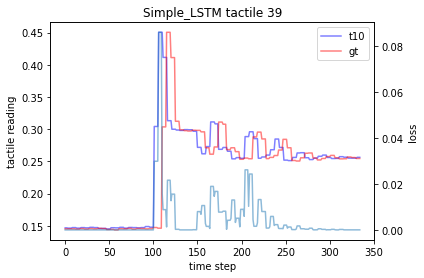

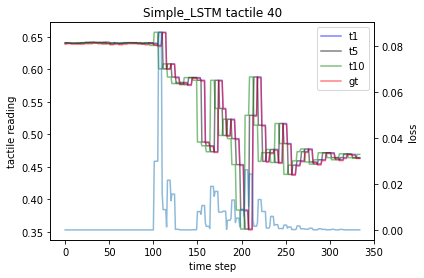

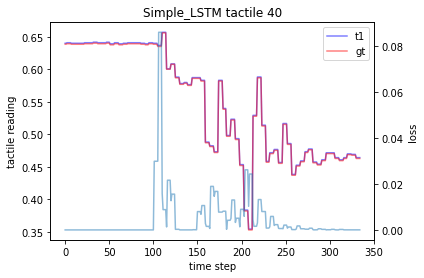

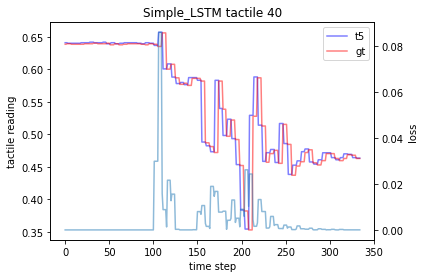

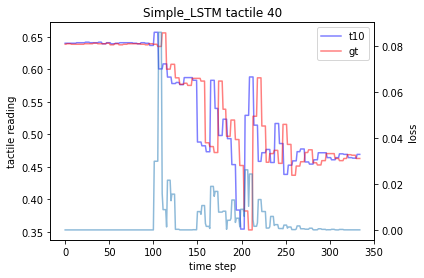

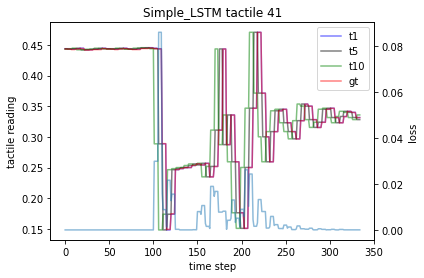

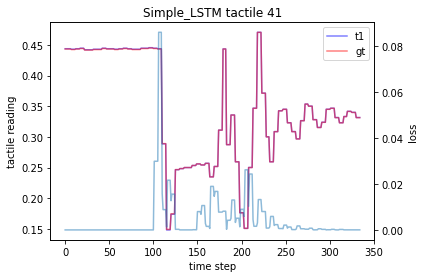

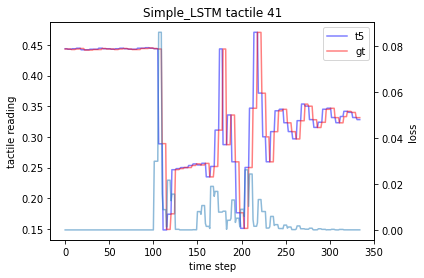

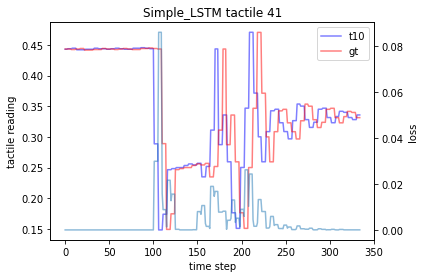

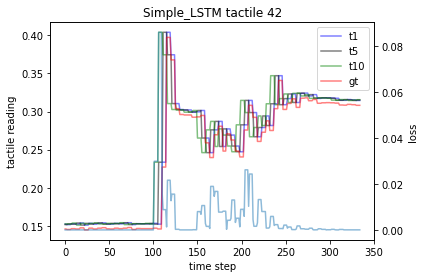

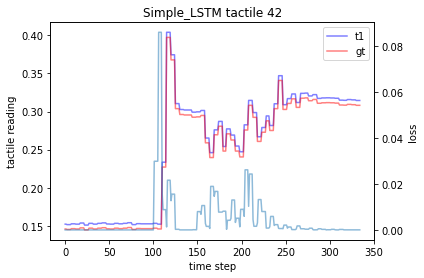

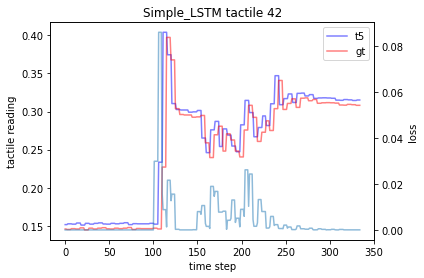

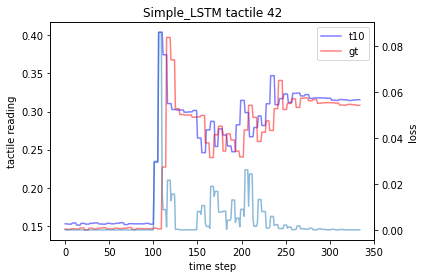

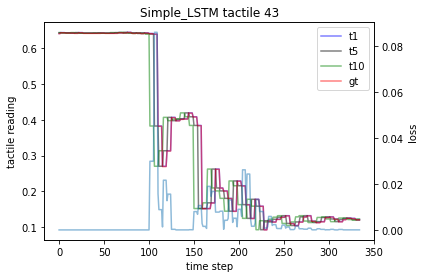

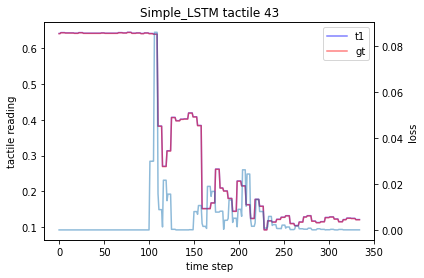

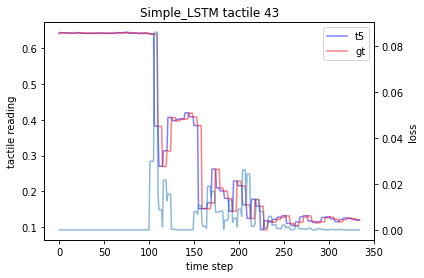

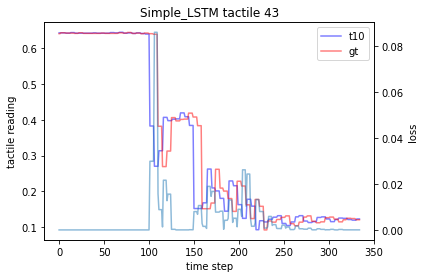

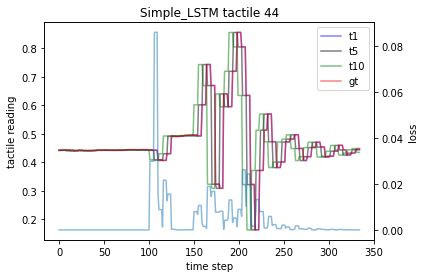

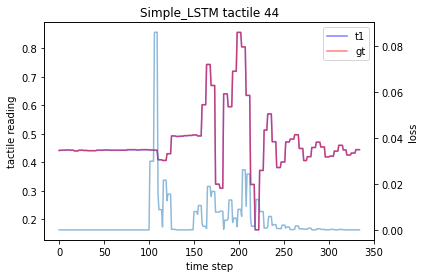

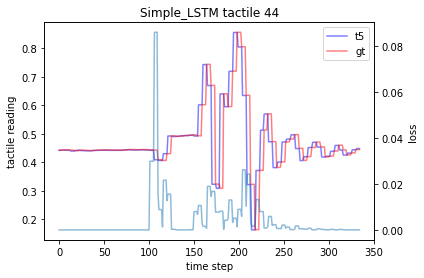

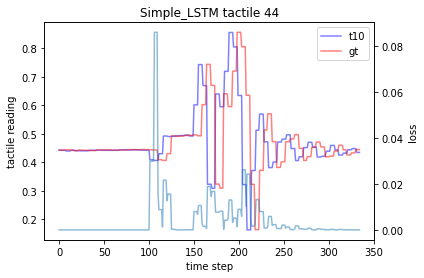

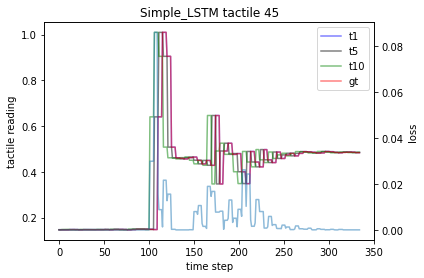

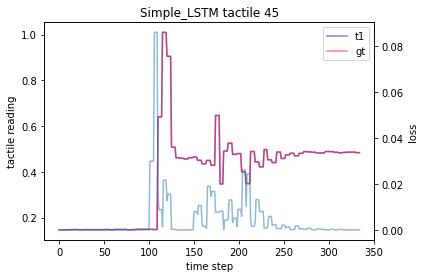

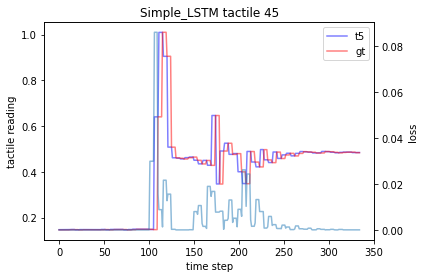

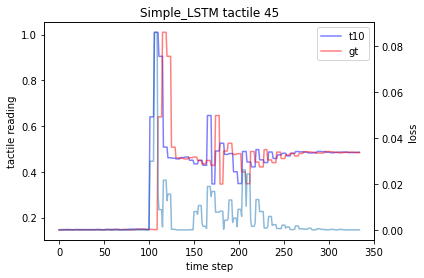

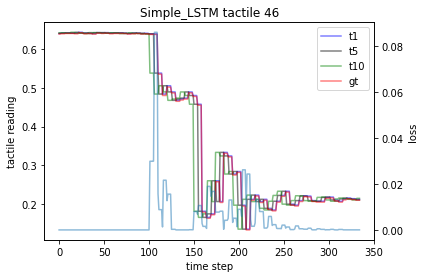

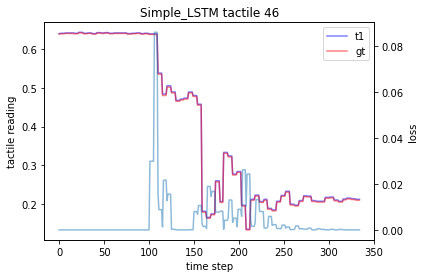

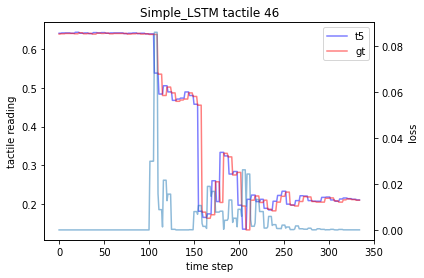

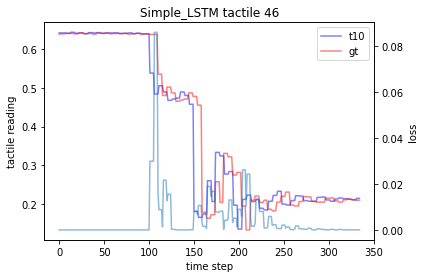

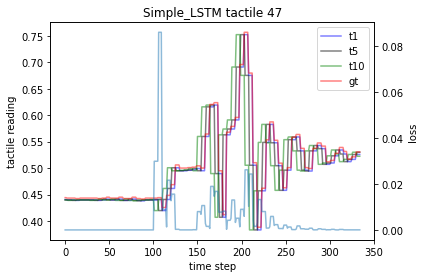

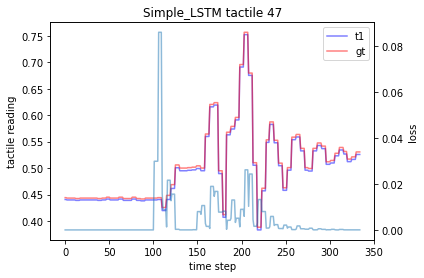

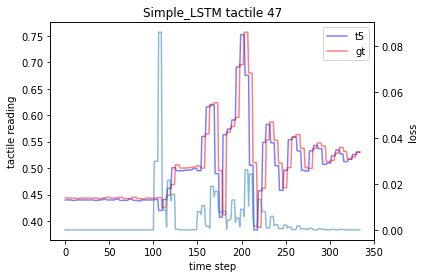

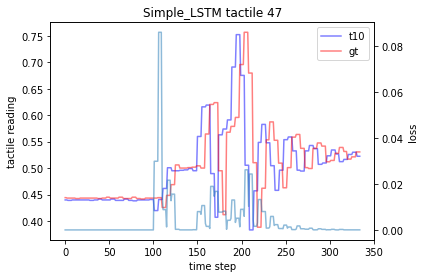

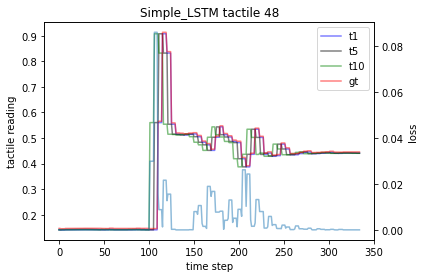

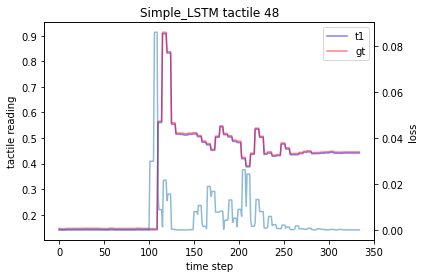

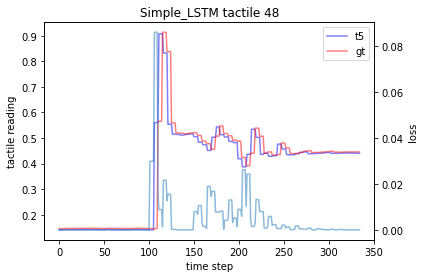

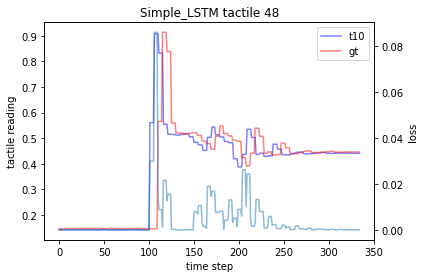

In [86]:
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
experiment_to_test = 106
for index, batch_set in enumerate(tactile_predictions):
    for batch in range(0, len(batch_set[0])):
        experiment = experiment_time_steps[index][0][batch][0]
        if experiment == experiment_to_test:
            prediction_values = batch_set[time_step_to_test_t1][batch]
            predicted_data_t1.append(prediction_values)
            prediction_values = batch_set[time_step_to_test_t5][batch]
            predicted_data_t5.append(prediction_values)
            prediction_values = batch_set[time_step_to_test_t9][batch]
            predicted_data_t9.append(prediction_values)
            gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
            groundtruth_data.append(gt_values)

# print(tactile_predictions[0])
# plt.plot([i for i in range(len(tactile_predictions[0]))], [i for i in range(len(tactile_predictions[0]))])
plt.show()        
mse_loss = torch.nn.MSELoss()
# mae_loss = torch.nn.MAELoss()
# print("MAE timestep + 1: ", np.mean(np.asarray([mse_loss(np.asarray(pred.cpu().detach()), np.asarray(gt.cpu().detach()))  for pred, gt in zip(predicted_data_t1, groundtruth_data)])))
# print("MAE timestep + 5: ", mse_loss(torch.tensor(predicted_data_t5), torch.tensor(groundtruth_data)))
# print("MAE timestep + 9: ", mse_loss(torch.tensor(predicted_data_t9), torch.tensor(groundtruth_data)))

# test data
index = 0
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t5 = []
        predicted_taxel_t9 = []
        # good = 140, 145 (lifting up the )
        for k in range(len(predicted_data_t1)):#310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][j+i].cpu().detach().numpy())
            predicted_taxel_t5.append(predicted_data_t5[k][j+i].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][j+i].cpu().detach().numpy())
            groundtruth_taxle.append(groundtruth_data[k][j+i].cpu().detach().numpy())

        index += 1
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot(predicted_taxel_t1, alpha=0.5, c="b", label="t1")
        ax1.plot(predicted_taxel_t5, alpha=0.5, c="k", label="t5")
        ax1.plot(predicted_taxel_t9, alpha=0.5, c="g", label="t10")
        ax1.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('loss')  # we already handled the x-label with ax1
        ax2.plot([i for i in range(len(groundtruth_data))], [mse_loss(predicted_data_t9[i].cpu().detach(), groundtruth_data[i].cpu().detach()) for i in range(len(groundtruth_data))], alpha=0.5)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Simple_LSTM tactile " + str(index))
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/concat_model_sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot(predicted_taxel_t1, alpha=0.5, c="b", label="t1")
        ax1.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('loss')  # we already handled the x-label with ax1
        ax2.plot([i for i in range(len(groundtruth_data))], [mse_loss(predicted_data_t9[i].cpu().detach(), groundtruth_data[i].cpu().detach()) for i in range(len(groundtruth_data))], alpha=0.5)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Simple_LSTM tactile " + str(index))
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/concat_model_T0sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot(predicted_taxel_t5, alpha=0.5, c="b", label="t5")
        ax1.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('loss')  # we already handled the x-label with ax1
        ax2.plot([i for i in range(len(groundtruth_data))], [mse_loss(predicted_data_t9[i].cpu().detach(), groundtruth_data[i].cpu().detach()) for i in range(len(groundtruth_data))], alpha=0.5)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Simple_LSTM tactile " + str(index))
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/concat_model_T5sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()
            
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot(predicted_taxel_t9, alpha=0.5, c="b", label="t10")
        ax1.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('loss')  # we already handled the x-label with ax1
        ax2.plot([i for i in range(len(groundtruth_data))], [mse_loss(predicted_data_t9[i].cpu().detach(), groundtruth_data[i].cpu().detach()) for i in range(len(groundtruth_data))], alpha=0.5)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Simple_LSTM tactile " + str(index))
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/concat_model_T10sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()
    
#         plt.plot(predicted_taxel_t1, alpha=0.5, c="b", label="t0")
#         plt.plot(predicted_taxel_t5, alpha=0.5, c="k", label="t5")
#         plt.plot(predicted_taxel_t9, alpha=0.5, c="g", label="t9")
#         plt.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
#         plt.ylim([0, 1])
#         plt.grid()
#         plt.legend(loc="upper right")
#         plt.savefig('/home/user/Pictures/simple_model_001/simple_model_test_sample_' + str(index) + '.png')
#         plt.show()
    

In [5]:
data_dir = '/home/user/Robotics/Data_sets/slip_detection/manual_slip_detection/'
BG = BatchGenerator(data_dir)
print("done")
train_full_loader, valid_full_loader, test_full_loader = BG.load_full_data()
# model = torch.load(model_path + "full_model")
# model.eval()

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].permute(1,0,2)
        tactile = batch_features[1].permute(1,0,2)
        experiment_time_steps.append([batch_features[3], batch_features[4]])
        tactile_groundtruth.append(tactile[context_frames:])


# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
experiment_to_test = 106
for index, batch_set in enumerate(tactile_groundtruth):
    for batch in range(0, len(batch_set[0])):
        experiment = experiment_time_steps[index][0][batch][0]
        if experiment == experiment_to_test:
            gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
            groundtruth_data.append(gt_values)


done


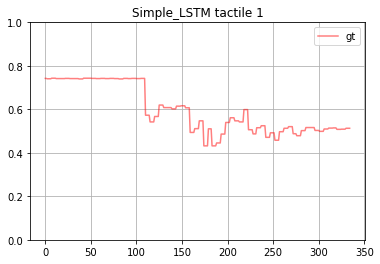

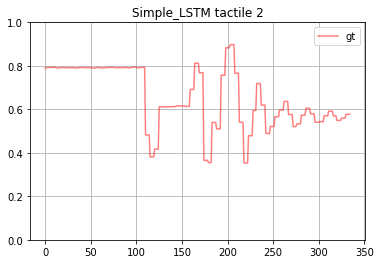

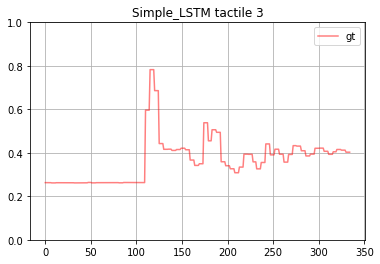

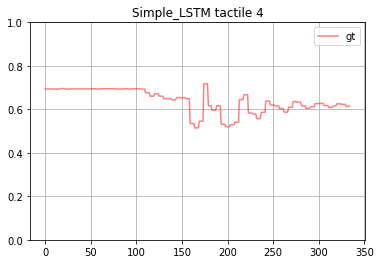

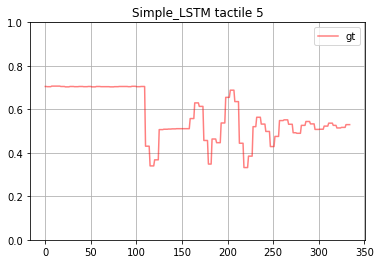

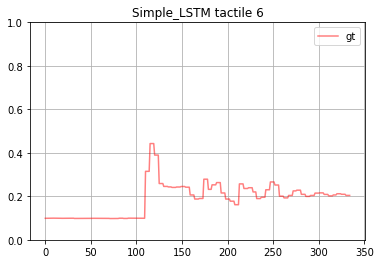

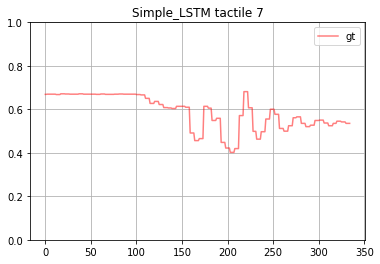

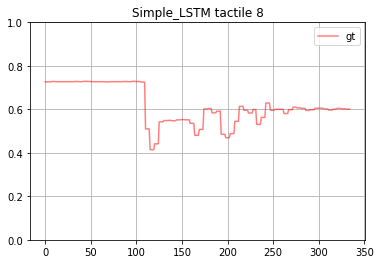

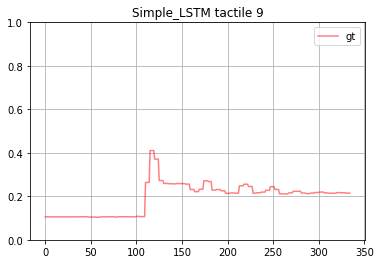

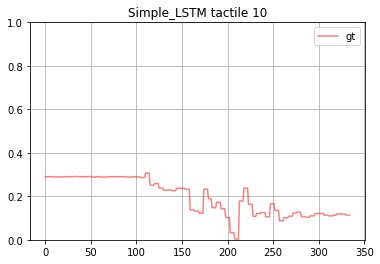

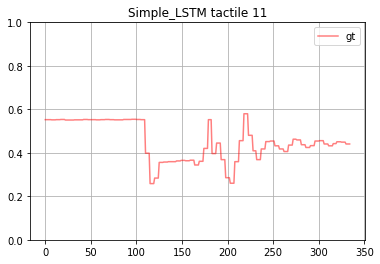

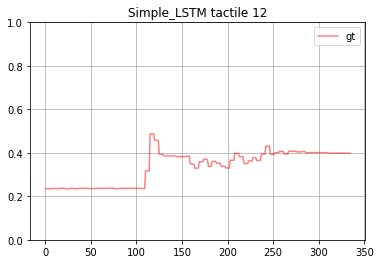

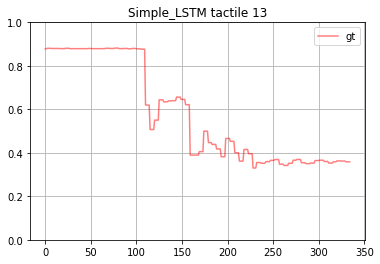

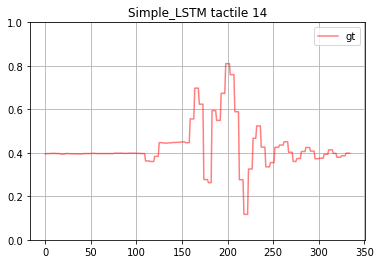

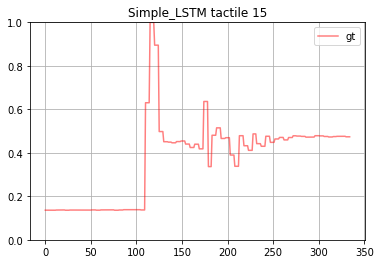

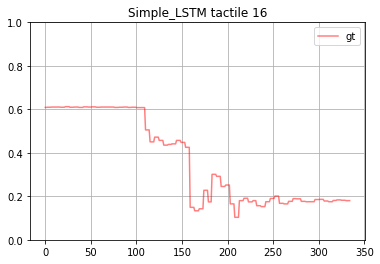

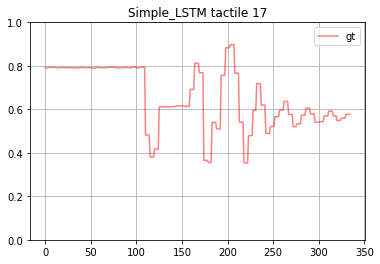

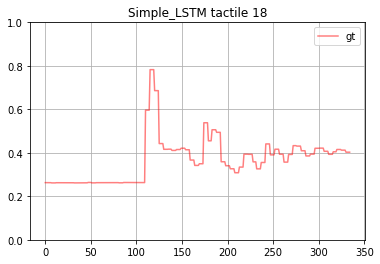

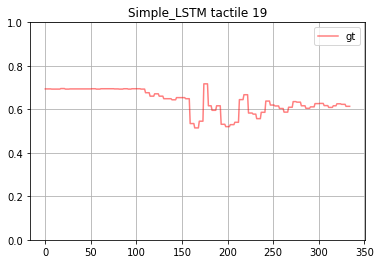

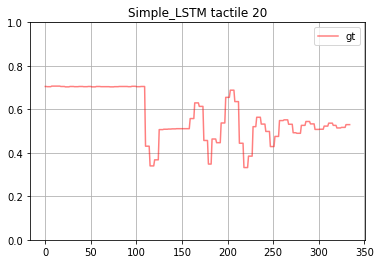

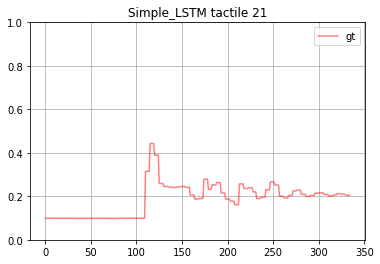

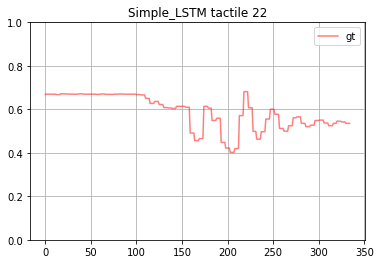

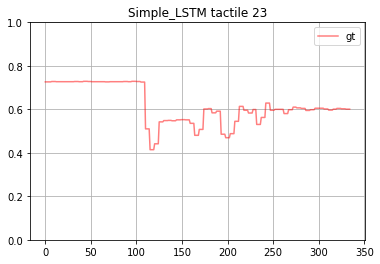

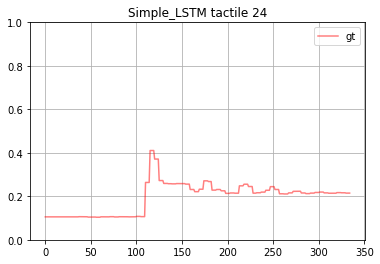

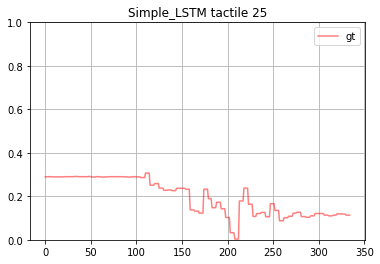

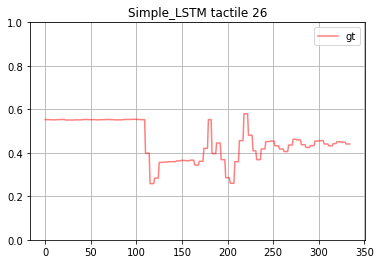

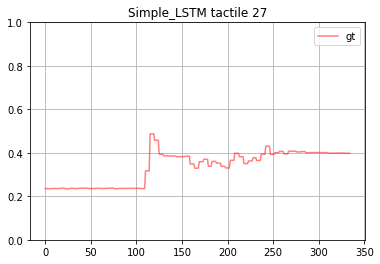

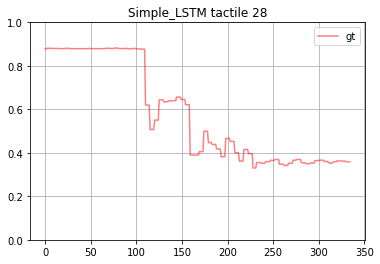

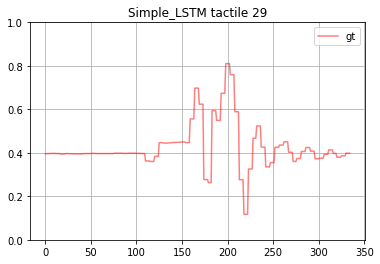

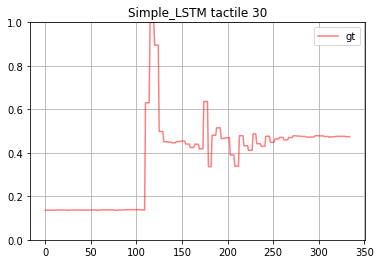

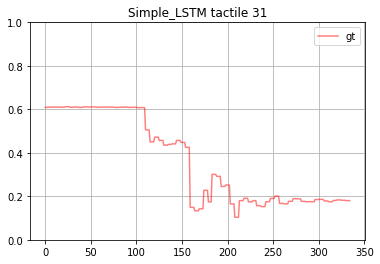

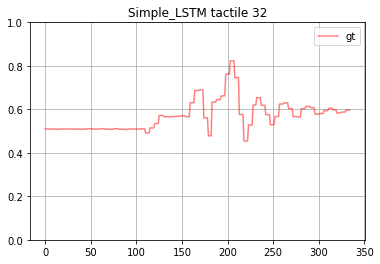

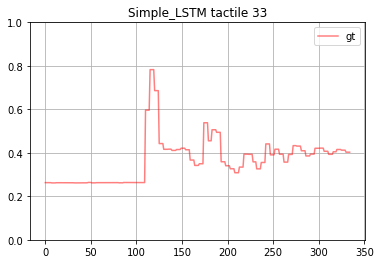

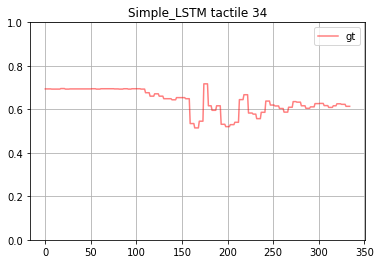

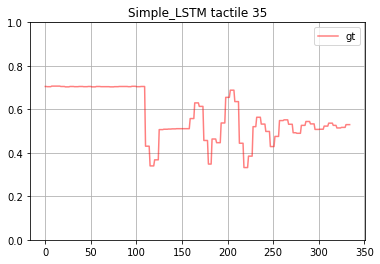

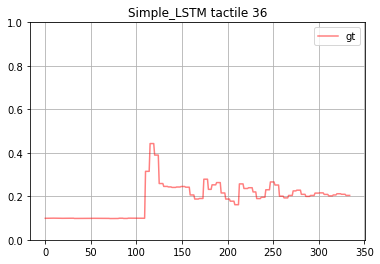

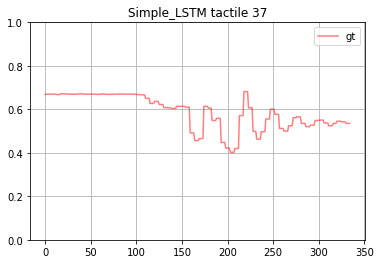

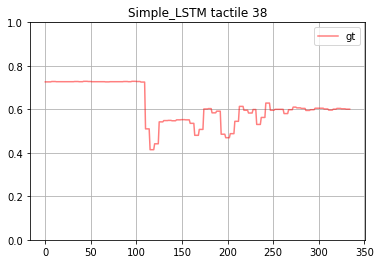

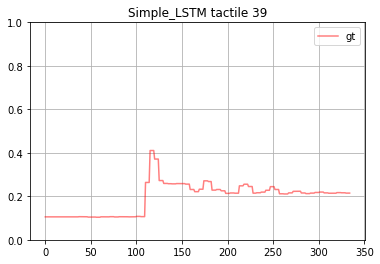

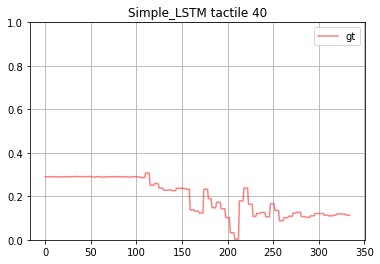

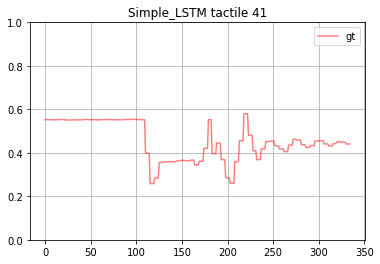

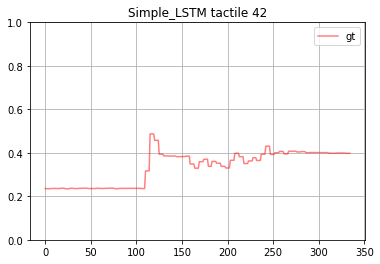

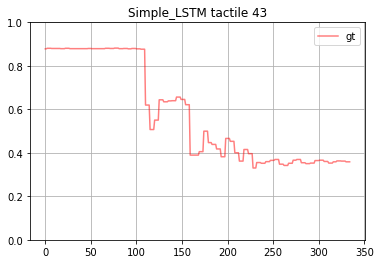

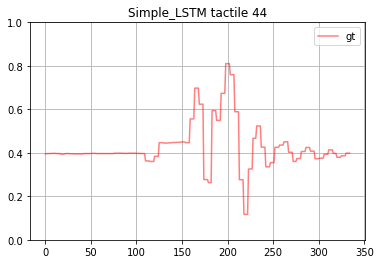

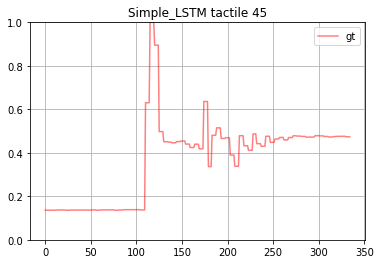

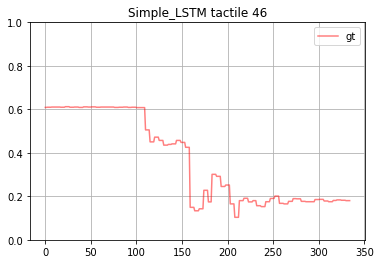

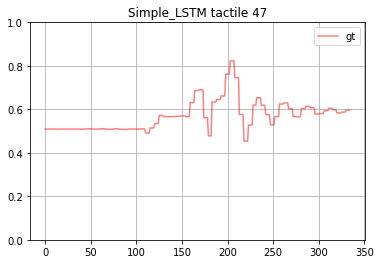

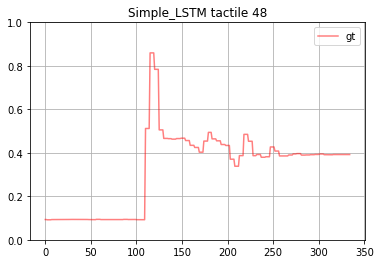

In [8]:

# test data
index = 0
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        # good = 140, 145 (lifting up the )
        for k in range(len(groundtruth_data)):#310, 325):#len(predicted_data_t1)):  # add in length of context data
            groundtruth_taxle.append(groundtruth_data[k][j+i].cpu().detach().numpy())

        index += 1
        plt.title("Simple_LSTM tactile " + str(index))
        plt.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        plt.ylim([0, 1])
        plt.grid()
        plt.legend(loc="upper right")
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/GT_only' + str(index) + '.png', dpi=300)
        plt.show()
    